In [8]:
from REs.MTDE import MTDE
from modules.AttnScorer import AttnScorer           # Returns pre-softmax raw attn score
from modules.GatedPooling import GatedPooling       # No attn inside, takes extrernal attn raw score from AttnScorer
from modules.ProjectionHead import ProjectionHead
from modules.ClassificationHead import ClassificationHead
from torchinfo import summary

class EmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
  #      self.physmamba = PhysMamba(...)
        self.mtde = MTDE(embedding_dim=256)
        self.attn_scorer = AttnScorer(input_dim=256)
        self.pooling = GatedPooling(input_dim=256)
        self.chunk_projection = ProjectionHead(input_dim=256, proj_dim=128)
        self.classifier = ClassificationHead(input_dim=256, num_classes=2)
        


model = EmotionModel()
print(model)


EmotionModel(
  (mtde): MTDE(
    (stem): Sequential(
      (0): Conv1d(1, 24, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): GroupNorm(6, 24, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv1d(24, 24, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): GroupNorm(6, 24, eps=1e-05, affine=True)
      (5): GELU(approximate='none')
      (6): Conv1d(24, 24, kernel_size=(3,), stride=(2,), padding=(1,))
      (7): Dropout(p=0.1, inplace=False)
    )
    (multi_scale_block): MultiScaleTemporalBlock(
      (branch_short): Sequential(
        (0): Conv1d(24, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): GELU(approximate='none')
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (branch_med): Sequential(
        (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(9,), dilation=(9,))
        (1): GELU(approximate='none')
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dil

In [3]:
!pip install torchinfo

In [1]:
import torch.nn as nn
# from neural_extractors.model.PhysMamba import PhysMamba

from REs.MTDE import MTDE
from modules.AttnScorer import AttnScorer           # Returns pre-softmax raw attn score
from modules.GatedPooling import GatedPooling       # No attn inside, takes extrernal attn raw score from AttnScorer
from modules.ProjectionHead import ProjectionHead
from modules.ClassificationHead import ClassificationHead


class EmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
  #      self.physmamba = PhysMamba(...)
        self.mtde = MTDE(embedding_dim=256)
        self.attn_scorer = AttnScorer(input_dim=256)
        self.pooling = GatedPooling(input_dim=256)
        self.chunk_projection = ProjectionHead(input_dim=256, proj_dim=128)
        self.classifier = ClassificationHead(input_dim=256, num_classes=2)
def count_parameters_per_module(model, exclude_modules=[]):
    param_dict = {}
    for name, module in model.named_children():
        if name.lower() in exclude_modules:
            continue
        count = sum(p.numel() for p in module.parameters() if p.requires_grad)
        param_dict[name] = count

    # top-level parameters not included in named_children()
    rest_params = sum(
        p.numel() for name, p in model.named_parameters()
        if all(not name.startswith(mod_name) for mod_name in list(param_dict.keys()) + exclude_modules)
        and p.requires_grad
    )
    if rest_params > 0:
        param_dict["(unassigned)"] = rest_params

    return param_dict

def print_param_table(param_dict):
    print(f"{'Module':<30} | {'Trainable Parameters':>20}")
    print("-" * 55)
    for name, count in param_dict.items():
        print(f"{name:<30} | {count:>20,}")
    print("-" * 55)
    total = sum(param_dict.values())
    print(f"{'Total':<30} | {total:>20,}")

model = EmotionModel()  # 사용자의 전체 모델 클래스

# PhysMamba 제외하고 모듈별 파라미터 수 계산
param_counts = count_parameters_per_module(model, exclude_modules=["physmamba"])
print_param_table(param_counts)



Module                         | Trainable Parameters
-------------------------------------------------------
mtde                           |               32,513
attn_scorer                    |               33,025
pooling                        |               65,792
chunk_projection               |               32,896
classifier                     |               33,666
-------------------------------------------------------
Total                          |              197,892


In [1]:
import re
import json
import csv
from collections import defaultdict

def extract_floats(text):
    return [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", text)]

def parse_full_log(filepath):
    parsed = {}
    current_epoch = None
    with open(filepath, 'r') as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        # ---------------- Epoch Start ----------------
        if "🧠 [Epoch" in line:
            current_epoch = int(re.search(r"Epoch (\d+)", line).group(1))
            parsed[current_epoch] = {
                "loss_weight": {},
                "loss": {},
                "attention": {},
                "supcon": {},
                "prediction": {
                    "gt": [],
                    "pred": [],
                    "correct": None
                },
                "valid": {}
            }

        if current_epoch is None:
            continue

        # ---------------- Loss Weights ----------------
        if "▸ CE" in line:
            parsed[current_epoch]["loss_weight"]["ce_weight"] = (
                float(re.search(r"([0-9.]+)", line).group()) if "Inactive" not in line else 0.0
            )
        if "▸ Contrastive" in line:
            match = re.search(r"\(([\d.]+)\)", line)
            if match:
                parsed[current_epoch]["loss_weight"]["contrastive_weight"] = float(match.group(1))
        if "▸ Top-K Ratio" in line:
            parsed[current_epoch]["loss_weight"]["topk_ratio"] = float(re.search(r"([0-9.]+)", line).group())

        # ---------------- Attention ----------------
        if "[DEBUG][Attn Sparsity]" in line:
            matches = re.findall(r"mean=([\d.]+), std=([\d.]+), entropy=([\d.]+)", line)
            if matches:
                mean, std, entropy = map(float, matches[0])
                parsed[current_epoch]["attention"] = {
                    "mean": mean, "std": std, "entropy": entropy
                }

        # ---------------- SupCon norm ----------------
        if "[DEBUG] norm mean=" in line:
            values = extract_floats(line)
            parsed[current_epoch]["supcon"]["norm_mean"] = values[0]
            parsed[current_epoch]["supcon"]["norm_std"] = values[1]
        if "pos_mask sum per sample" in line:
            values = extract_floats(line)
            parsed[current_epoch]["supcon"]["pos_mask_avg"] = sum(values) / len(values)

        # ---------------- Loss Breakdown ----------------
        if "▸ CE" in line:
            if "Inactive" in line:
                parsed[current_epoch]["loss_weight"]["ce_weight"] = 0.0
            else:
                match = re.search(r"▸ CE\s*:\s*([\d.]+)", line)
                if match:
                    parsed[current_epoch]["loss_weight"]["ce_weight"] = float(match.group(1))

        if "▸ Contrastive" in line and "SKIPPED" not in line:
            match = re.search(r"Contrastive: ([\d.]+)\s*×", line)
            if match:
                parsed[current_epoch]["loss"]["contrastive"] = float(match.group(1))

        if "▸ Sparsity" in line and "SKIPPED" not in line:
            match = re.search(r"Sparsity\s*:\s*([\d.]+)", line)
            if match:
                parsed[current_epoch]["loss"]["sparsity"] = float(match.group(1))

        if "▶ Total Loss" in line:
            parsed[current_epoch]["loss"]["total"] = float(re.findall(r"Total Loss\s*:\s*([\d.]+)", line)[0])

        # ---------------- Prediction ----------------
        if "▸ Session" in line and "GT:" in line and "Pred:" in line:
            match = re.search(r"GT: (\d+) \| Pred: (\d+)", line)
            if match:
                gt, pred = map(int, match.groups())
                parsed[current_epoch]["prediction"]["gt"].append(gt)
                parsed[current_epoch]["prediction"]["pred"].append(pred)
        
        # ---------------- Validation ----------------
        elif "[VALID] Avg Entropy:" in line:
            val_entropy = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
            parsed[current_epoch]["valid"] = parsed[current_epoch].get("valid", {})
            parsed[current_epoch]["valid"]["entropy"] = val_entropy

        elif "[VALID] Avg Loss:" in line:
            val_loss = float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
            parsed[current_epoch]["valid"]["loss"] = val_loss

        elif "Epoch" in line and "- Valid Loss:" in line:
            match = re.search(r"Valid Loss: ([0-9.]+), Acc: ([0-9.]+), F1: ([0-9.]+)", line)
            if match:
                val_loss, val_acc, val_f1 = map(float, match.groups())
                parsed[current_epoch]["valid"].update({
                    "loss": val_loss,
                    "acc": val_acc,
                    "f1": val_f1
                })

        # ---------------- Test ----------------
        elif "[best_" in line and "Acc:" in line:
            test_type = re.search(r"\[(best_.*?)\]", line).group(1)  # e.g., best_acc
            acc_f1 = re.findall(r"Acc: ([0-9.]+), F1: ([0-9.]+)", line)
            if acc_f1:
                acc, f1 = map(float, acc_f1[0])
                parsed.setdefault("test", {})
                parsed["test"][test_type] = {
                    "acc": acc,
                    "f1": f1
                }

        elif "[best_" in line and "Confusion Matrix" in line:
            current_test_type = re.search(r"\[(best_.*?)\]", line).group(1)
            matrix_lines = lines[idx+1:idx+3]
            cm = [[int(num) for num in re.findall(r"\d+", l)] for l in matrix_lines]
            if "test" in parsed and current_test_type in parsed["test"]:
                parsed["test"][current_test_type]["confusion_matrix"] = cm


    # ---------------- Accuracy ----------------
    for epoch in parsed:
        gts = parsed[epoch]["prediction"]["gt"]
        preds = parsed[epoch]["prediction"]["pred"]
        if gts and preds and len(gts) == len(preds):
            correct = sum(g == p for g, p in zip(gts, preds))
            parsed[epoch]["prediction"]["correct"] = correct / len(gts)

    return parsed


def save_as_json(parsed, path="parsed_log.json"):
    with open(path, 'w') as f:
        json.dump(parsed, f, indent=4)
    print(f"✅ JSON Completed → {path}")


def save_as_csv(parsed, path="parsed_log.csv"):
    fieldnames = [
        "epoch", "ce_weight", "contrastive_weight", "topk_ratio",
        "ce_loss", "contrastive_loss", "sparsity_loss", "total_loss",
        "attn_entropy", "norm_mean", "norm_std", "pos_mask_avg", "accuracy",
        "valid_loss", "valid_acc", "valid_f1"
    ]

    with open(path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for epoch, data in parsed.items():
            row = {
                "epoch": epoch,
                "ce_weight": data["loss_weight"].get("ce_weight"),
                "contrastive_weight": data["loss_weight"].get("contrastive_weight"),
                "topk_ratio": data["loss_weight"].get("topk_ratio"),
                "ce_loss": data["loss"].get("ce"),
                "contrastive_loss": data["loss"].get("contrastive"),
                "sparsity_loss": data["loss"].get("sparsity"),
                "total_loss": data["loss"].get("total"),
                "attn_entropy": data["attention"].get("entropy"),
                "norm_mean": data["supcon"].get("norm_mean"),
                "norm_std": data["supcon"].get("norm_std"),
                "pos_mask_avg": data["supcon"].get("pos_mask_avg"),
                "accuracy": data["prediction"].get("correct"),
                "valid_loss": data["valid"].get("loss"),
                "valid_acc": data["valid"].get("acc"),
                "valid_f1": data["valid"].get("f1"),
            }
            writer.writerow(row)
    print(f"✅ CSV Completed → {path}")

if __name__ == "__main__":
    parsed = parse_full_log("/home/changmin/TempReMOTION.txt")
    save_as_json(parsed, "parsed_log_.json")
    save_as_csv(parsed, "parsed_log_.csv")


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
'''
def split_log_file(input_path, lines_per_file=5000):
    with open(input_path, 'r') as infile:
        lines = infile.readlines()

    for i in range(0, len(lines), lines_per_file):
        chunk = lines[i:i+lines_per_file]
        with open(f"./parsed_logs/log_chunk_{i//lines_per_file:03}.txt", 'w') as out:
            out.writelines(chunk)

split_log_file("/home/changmin/TempReMOTION.txt", lines_per_file=5000)
'''

# Unified Script

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import butter, filtfilt, find_peaks

source_dir = "/home/changmin/data/Sessions"
output_dir = "/home/changmin/data/MAHNOB_HCI_Emotion"
csv_file = os.path.join(output_dir, "emotion_labels.csv")
os.makedirs(output_dir, exist_ok=True)
data_list = []

def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# HR
def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:
        return np.nan
    ecg_signal = ecg_signal - np.mean(ecg_signal)
    ecg_signal = bandpass_filter(ecg_signal, fs)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    if len(peaks) < 2:
        return np.nan
    rr_intervals = np.diff(peaks) / fs
    hr_values = 60 / rr_intervals
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]
    return np.mean(hr_values) if len(hr_values) > 0 else np.nan

# all sessions
for session in os.listdir(source_dir):
    session_path = os.path.join(source_dir, session)
    if not os.path.isdir(session_path):
        continue

    xml_file = ecg_file = video_file = None

    for file in os.listdir(session_path):
        if file.endswith(".xml"):
            xml_file = os.path.join(session_path, file)
        elif file.endswith(".bdf"):
            ecg_file = os.path.join(session_path, file)

    if not xml_file:
        continue

    tree = ET.parse(xml_file)
    root = tree.getroot()

    if root.attrib.get("isStim") != "1":
        continue

    subject_elem = root.find("subject")
    subject_id = subject_elem.attrib.get("id") if subject_elem is not None else None
    # if subject_id in ["3", "9", "16"]:
        # continue

    felt_emo = root.attrib.get("feltEmo")
    felt_arsl = root.attrib.get("feltArsl")
    felt_vlnc = root.attrib.get("feltVlnc")
    # vid_begin = root.attrib.get("vidBeginSmp")
    # vid_end = root.attrib.get("vidEndSmp")
    vid_rate = root.attrib.get("vidRate")
    stimulus_dur = root.attrib.get("cutLenSec")
    '''
    if not all([felt_emo, felt_arsl, felt_vlnc, vid_begin, vid_end, vid_rate]):
        continue

    dur_start_sec = float(vid_begin) / float(vid_rate)
    dur_end_sec = float(vid_end) / float(vid_rate)
    '''
    entry = {
        "Session": session,
        "subject_id": subject_id,
        "feltEmo": int(felt_emo),
        "feltArsl": int(felt_arsl),
        "feltVlnc": int(felt_vlnc),
        # "dur_start_sec": dur_start_sec,
        # "dur_end_sec": dur_end_sec,
        "stimulus_dur": stimulus_dur,
        "HR": np.nan
    }

    for track in root.findall("track"):
        if track.attrib.get("type") == "Video" and track.attrib.get("color") == "1":
            video_file = os.path.join(session_path, track.attrib.get("filename"))
            break

    if ecg_file:
        try:
            f = pyedflib.EdfReader(ecg_file)
            fs = 256
            hr_candidates = []
            for ch in [33, 34, 35]:
                try:
                    ecg = f.readSignal(ch)
                    hr = calculate_hr(ecg, fs)
                    if not np.isnan(hr):
                        hr_candidates.append(hr)
                except:
                    continue
            f.close()
            entry["HR"] = np.median(hr_candidates) if hr_candidates else np.nan
        except Exception as e:
            print(f"HR error in session {session}: {e}")

    if video_file:
        try:
            target_session_dir = os.path.join(output_dir, session)
            os.makedirs(target_session_dir, exist_ok=True)
            target_video_path = os.path.join(target_session_dir, f"{session}.avi")
            shutil.copy(video_file, target_video_path)
        except Exception as e:
            print(f"Video copy error in session {session}: {e}")

    data_list.append(entry)

def map_3C_Arsl(feltEmo):
    if feltEmo in [0, 2, 5]: return 0
    elif feltEmo in [4, 11]: return 1
    elif feltEmo in [1, 3, 6, 12]: return 2
    else: return None

def map_3C_Vlnc(feltEmo):
    if feltEmo in [1, 2, 3, 5, 12]: return 0
    elif feltEmo in [0, 6]: return 1
    elif feltEmo in [4, 11]: return 2
    else: return None


df = pd.DataFrame(data_list)
df["BC_Arsl"] = df["feltArsl"].apply(lambda x: 0 if 1 <= x <= 4 else 1 if 5 <= x <= 9 else None)
df["BC_Vlnc"] = df["feltVlnc"].apply(lambda x: 0 if 1 <= x <= 4 else 1 if 5 <= x <= 9 else None)
df["3C_Arsl"] = df["feltEmo"].apply(map_3C_Arsl)
df["3C_Vlnc"] = df["feltEmo"].apply(map_3C_Vlnc)

# save
df.to_csv(csv_file, index=False)
print(f"✅ Final CSV saved at {csv_file} with {len(df)} entries.")


✅ Final CSV saved at /home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv with 547 entries.


# Feature Engineering for Emotion Recognition

 ## 2 classes filtering

In [2]:
import pandas as pd
 
# read csv file
df = pd.read_csv('/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv')
df.head()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR
0,2762,22,5,6,2,69.031442
1,3518,28,5,2,1,61.935484
2,670,6,4,6,8,66.580198
3,2748,22,0,3,5,69.563572
4,2864,23,12,4,3,61.935484


In [19]:
# feltVlnc and feltArsl
# 1~4: 0(Low), 5~9: 1(High)
df['BC_Vlnc'] = df['feltVlnc'].apply(lambda x: 0 if 1 <= x <= 4 else 1 if 5 <= x <= 9 else None)
df['BC_Arsl'] = df['feltArsl'].apply(lambda x: 0 if 1 <= x <= 4 else 1 if 5 <= x <= 9 else None)

df.head()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR,3C_Arsl,3C_Vlnc,BC_Vlnc,BC_Arsl
0,2762,22,5,6,2,69.031442,0,0,0,1
1,3518,28,5,2,1,61.935484,0,0,0,0
2,670,6,4,6,8,66.580198,1,2,1,1
3,2748,22,0,3,5,69.563572,0,1,1,0
4,2864,23,12,4,3,61.935484,2,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Session     547 non-null    int64  
 1   subject_id  547 non-null    int64  
 2   feltEmo     547 non-null    int64  
 3   feltArsl    547 non-null    int64  
 4   feltVlnc    547 non-null    int64  
 5   HR          547 non-null    float64
 6   3C_Arsl     547 non-null    int64  
 7   3C_Vlnc     547 non-null    int64  
 8   BC_Vlnc     547 non-null    int64  
 9   BC_Arsl     547 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 42.9 KB


In [5]:
BC_Vlnc_num = df['BC_Vlnc'].value_counts()
BC_Arsl_num = df['BC_Arsl'].value_counts()
print(BC_Vlnc_num)
print(BC_Arsl_num)

BC_Vlnc
1    296
0    251
Name: count, dtype: int64
BC_Arsl
1    277
0    270
Name: count, dtype: int64


In [6]:
subject = df['subject_id'].value_counts()
print(subject)

subject_id
22    20
28    20
6     20
23    20
20    20
1     20
29    20
4     20
13    20
17    20
24    20
26    20
14    20
2     20
8     20
27    20
5     20
25    20
11    20
18    20
10    20
19    20
7     20
30    20
21    20
3     17
16    16
9     14
Name: count, dtype: int64


In [7]:
subject_counts = df.groupby('subject_id')[['BC_Vlnc', 'BC_Arsl']].count()
print("Count of BC_Vlnc and BC_Arsl for each subject:")
print(subject_counts)

Count of BC_Vlnc and BC_Arsl for each subject:
            BC_Vlnc  BC_Arsl
subject_id                  
1                20       20
2                20       20
3                17       17
4                20       20
5                20       20
6                20       20
7                20       20
8                20       20
9                14       14
10               20       20
11               20       20
13               20       20
14               20       20
16               16       16
17               20       20
18               20       20
19               20       20
20               20       20
21               20       20
22               20       20
23               20       20
24               20       20
25               20       20
26               20       20
27               20       20
28               20       20
29               20       20
30               20       20


In [8]:
# Alternatively, if you want to see the value counts (e.g., 0 vs 1) for each subject:
for subject, group in df.groupby('subject_id'):
    print(f"Subject {subject}:")
    print("BC_Vlnc value counts:")
    print(group['BC_Vlnc'].value_counts())
    print("BC_Arsl value counts:")
    print(group['BC_Arsl'].value_counts())
    print("-" * 40)

Subject 1:
BC_Vlnc value counts:
BC_Vlnc
1    11
0     9
Name: count, dtype: int64
BC_Arsl value counts:
BC_Arsl
1    16
0     4
Name: count, dtype: int64
----------------------------------------
Subject 2:
BC_Vlnc value counts:
BC_Vlnc
1    10
0    10
Name: count, dtype: int64
BC_Arsl value counts:
BC_Arsl
1    11
0     9
Name: count, dtype: int64
----------------------------------------
Subject 3:
BC_Vlnc value counts:
BC_Vlnc
1    11
0     6
Name: count, dtype: int64
BC_Arsl value counts:
BC_Arsl
0    9
1    8
Name: count, dtype: int64
----------------------------------------
Subject 4:
BC_Vlnc value counts:
BC_Vlnc
1    10
0    10
Name: count, dtype: int64
BC_Arsl value counts:
BC_Arsl
1    11
0     9
Name: count, dtype: int64
----------------------------------------
Subject 5:
BC_Vlnc value counts:
BC_Vlnc
1    12
0     8
Name: count, dtype: int64
BC_Arsl value counts:
BC_Arsl
1    15
0     5
Name: count, dtype: int64
----------------------------------------
Subject 6:
BC_Vlnc val

In [9]:
import pandas as pd
from tabulate import tabulate  # pip install tabulate


# Group by subject_id and count values for BC_Vlnc and BC_Arsl
table_list = []
for subject, group in df.groupby('subject_id'):
    # Count occurrences for each value (0 and 1)
    bc_vlnc_counts = group['BC_Vlnc'].value_counts().sort_index()
    bc_arsl_counts = group['BC_Arsl'].value_counts().sort_index()
    count_0_vlnc = bc_vlnc_counts.get(0, 0)
    count_1_vlnc = bc_vlnc_counts.get(1, 0)
    count_0_arsl = bc_arsl_counts.get(0, 0)
    count_1_arsl = bc_arsl_counts.get(1, 0)
    table_list.append([subject, count_0_vlnc, count_1_vlnc, count_0_arsl, count_1_arsl])

# Define headers
headers = ["Subject", "BC_Vlnc (0)", "BC_Vlnc (1)", "BC_Arsl (0)", "BC_Arsl (1)"]

# Print table in grid format
print(tabulate(table_list, headers=headers, tablefmt="grid"))


+-----------+---------------+---------------+---------------+---------------+
|   Subject |   BC_Vlnc (0) |   BC_Vlnc (1) |   BC_Arsl (0) |   BC_Arsl (1) |
+===========+===============+===============+===============+===============+
|         1 |             9 |            11 |             4 |            16 |
+-----------+---------------+---------------+---------------+---------------+
|         2 |            10 |            10 |             9 |            11 |
+-----------+---------------+---------------+---------------+---------------+
|         3 |             6 |            11 |             9 |             8 |
+-----------+---------------+---------------+---------------+---------------+
|         4 |            10 |            10 |             9 |            11 |
+-----------+---------------+---------------+---------------+---------------+
|         5 |             8 |            12 |             5 |            15 |
+-----------+---------------+---------------+---------------+---

/tmp/ipykernel_357179/1779944491.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


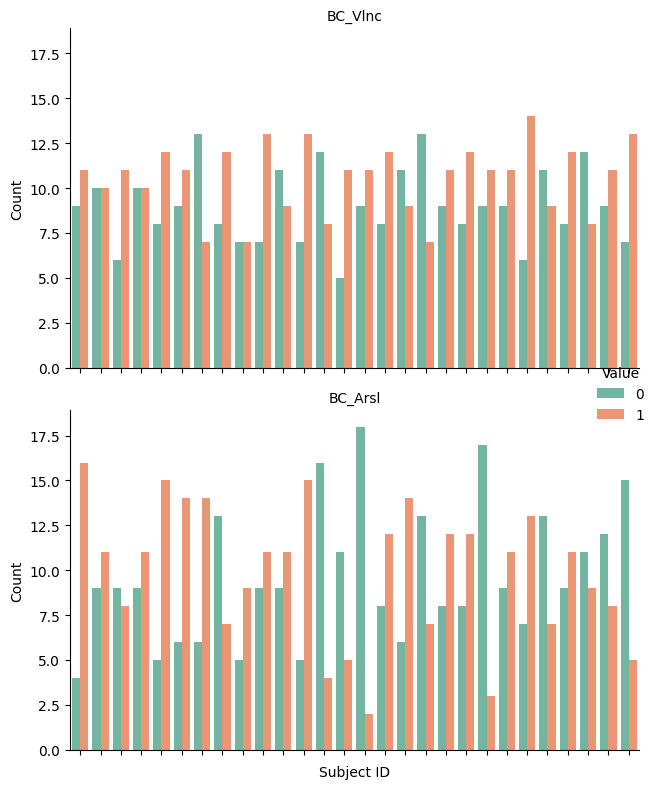

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# BC_Vlnc와 BC_Arsl을 row로 구분하기 위해 melt
df_melt = df.melt(
    id_vars="subject_id",
    value_vars=["BC_Vlnc", "BC_Arsl"],
    var_name="Label_Type",
    value_name="Value"
)

# catplot에서 row="Label_Type"로 설정하면, BC_Vlnc와 BC_Arsl이 위아래로 나뉨
g = sns.catplot(
    data=df_melt,
    kind="count",
    x="subject_id",
    hue="Value",
    row="Label_Type",
    row_order=["BC_Vlnc", "BC_Arsl"],  # 순서를 명시적으로 지정
    height=4,
    aspect=1.5,
    palette="Set2",
    dodge=True
)

# 제목, 축 레이블 등 설정
g.set_axis_labels("Subject ID", "Count")
g.set_titles("{row_name}")  # 각 row에 해당하는 레이블 이름(BC_Vlnc, BC_Arsl)

# 범례 제목 설정
if g._legend is not None:
    g._legend.set_title("Value")

# x축 라벨 겹치지 않도록 회전
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


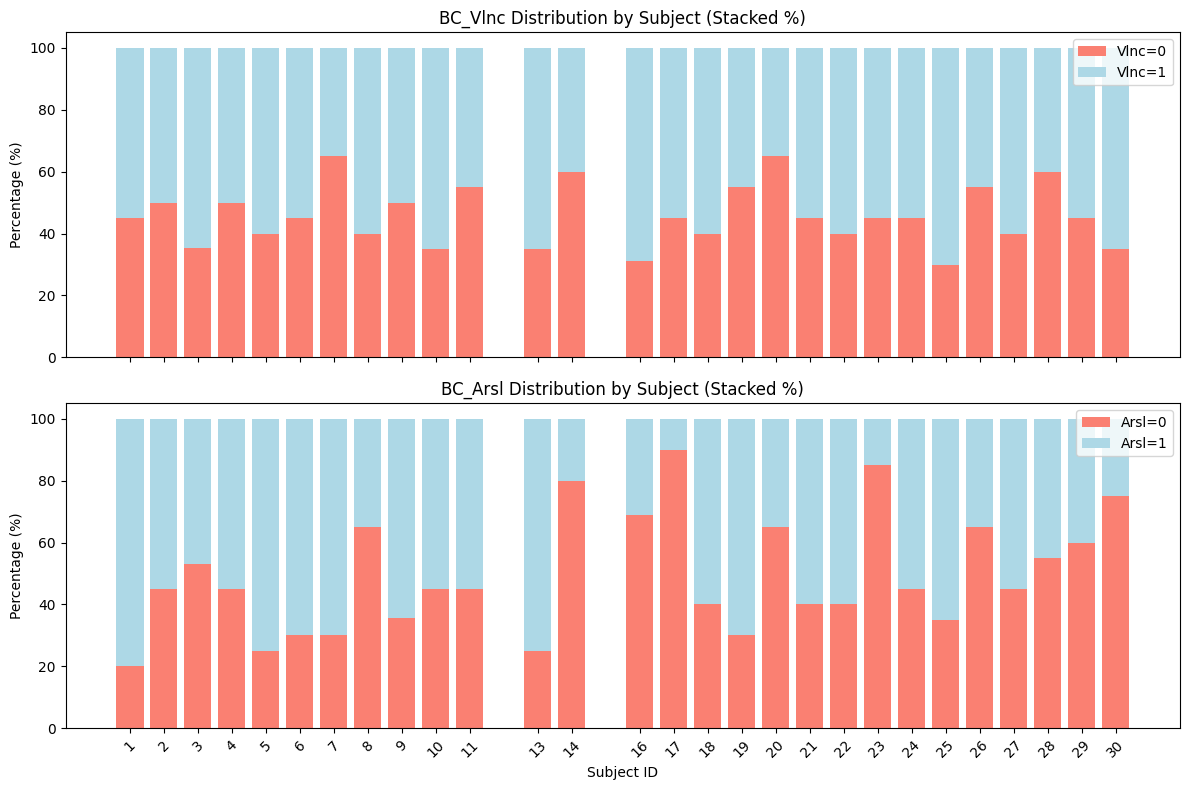

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# subject_id별, BC_Vlnc=0,1 / BC_Arsl=0,1 개수 계산
counts = df.groupby("subject_id")[["BC_Vlnc", "BC_Arsl"]].value_counts().reset_index(name="Count")
# 예: counts의 columns: [subject_id, BC_Vlnc, BC_Arsl, Count]

# (예시) BC_Vlnc와 BC_Arsl를 각각 별도의 스택 막대 그래프로 만들기 위해 pivot
# BC_Vlnc: subject_id별로 0,1 개수
counts_vlnc = df.groupby(["subject_id", "BC_Vlnc"]).size().unstack(fill_value=0)
counts_vlnc.columns = ["Vlnc_0", "Vlnc_1"]

# BC_Arsl: subject_id별로 0,1 개수
counts_arsl = df.groupby(["subject_id", "BC_Arsl"]).size().unstack(fill_value=0)
counts_arsl.columns = ["Arsl_0", "Arsl_1"]

# subject_id 정렬
counts_vlnc = counts_vlnc.sort_index()
counts_arsl = counts_arsl.sort_index()

# 비율(%) 계산
counts_vlnc_pct = counts_vlnc.apply(lambda row: row / row.sum() * 100, axis=1)
counts_arsl_pct = counts_arsl.apply(lambda row: row / row.sum() * 100, axis=1)

# 두 subplot(2행 1열)으로 구성: 위=BC_Vlnc, 아래=BC_Arsl
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# BC_Vlnc stacked bar
axes[0].bar(counts_vlnc_pct.index, counts_vlnc_pct["Vlnc_0"], label="Vlnc=0", color="salmon")
axes[0].bar(counts_vlnc_pct.index, counts_vlnc_pct["Vlnc_1"], bottom=counts_vlnc_pct["Vlnc_0"], label="Vlnc=1", color="lightblue")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("BC_Vlnc Distribution by Subject (Stacked %)")
axes[0].legend()

# BC_Arsl stacked bar
axes[1].bar(counts_arsl_pct.index, counts_arsl_pct["Arsl_0"], label="Arsl=0", color="salmon")
axes[1].bar(counts_arsl_pct.index, counts_arsl_pct["Arsl_1"], bottom=counts_arsl_pct["Arsl_0"], label="Arsl=1", color="lightblue")
axes[1].set_xlabel("Subject ID")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("BC_Arsl Distribution by Subject (Stacked %)")
axes[1].legend()

plt.xticks(counts_vlnc_pct.index, rotation=45)
plt.tight_layout()
plt.show()


 ## 3 classes filtering

In [12]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv')

# Define mapping function for 3C_Arsl based on feltEmo
def map_3C_Arsl(feltEmo):
    # If feltEmo is in [0, 2, 5], return 0
    if feltEmo in [0, 2, 5]: # Sadness, Disgust, Neutral
        return 0 # Calm
    # If feltEmo is in [4, 11], return 1
    elif feltEmo in [4, 11]: # Joy and happiness, amusement
        return 1 # Medium arousal
    # If feltEmo is in [1, 3, 6, 12], return 2
    elif feltEmo in [1, 3, 6, 12]: # Anger, Fear, Surprise, Anxiety
        return 2 # Excited/activated
    else:
        return None  # or np.nan for unexpected values

# Define mapping function for 3C_Vlnc based on feltEmo
def map_3C_Vlnc(feltEmo):
    # If feltEmo is in [7, 6, 3, 1, 9], return 0
    if feltEmo in [1, 2, 3, 5, 12]: # Anger, Disgust, Fear, Sadness, Anxiety
        return 0 # Unpleasant
    # If feltEmo is in [0, 6], return 1
    elif feltEmo in [0, 6]: # Neutral, Surprise
        return 1 # Neutral valence
    # If feltEmo is in [4, 11], return 2
    elif feltEmo in [4, 11]: # Joy and happiness, Amusement
        return 2 # Pleasant
    else:
        return None

# Create new columns by applying the mapping functions to the 'feltEmo' column
df['3C_Arsl'] = df['feltEmo'].apply(map_3C_Arsl)
df['3C_Vlnc'] = df['feltEmo'].apply(map_3C_Vlnc)

# Print the first few rows of the relevant columns to check the results
print(df[['subject_id', 'feltEmo', '3C_Arsl', '3C_Vlnc']].head())

   subject_id  feltEmo  3C_Arsl  3C_Vlnc
0          22        5        0        0
1          28        5        0        0
2           6        4        1        2
3          22        0        0        1
4          23       12        2        0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Session     547 non-null    int64  
 1   subject_id  547 non-null    int64  
 2   feltEmo     547 non-null    int64  
 3   feltArsl    547 non-null    int64  
 4   feltVlnc    547 non-null    int64  
 5   HR          547 non-null    float64
 6   3C_Arsl     547 non-null    int64  
 7   3C_Vlnc     547 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 34.3 KB


In [14]:
cnt_3C_Vlnc = df['3C_Vlnc'].value_counts()
cnt_3C_Arsl = df['3C_Arsl'].value_counts()
print(cnt_3C_Vlnc)
print(cnt_3C_Arsl)

3C_Vlnc
0    217
2    190
1    140
Name: count, dtype: int64
3C_Arsl
0    240
1    190
2    117
Name: count, dtype: int64


/tmp/ipykernel_357179/3361389098.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


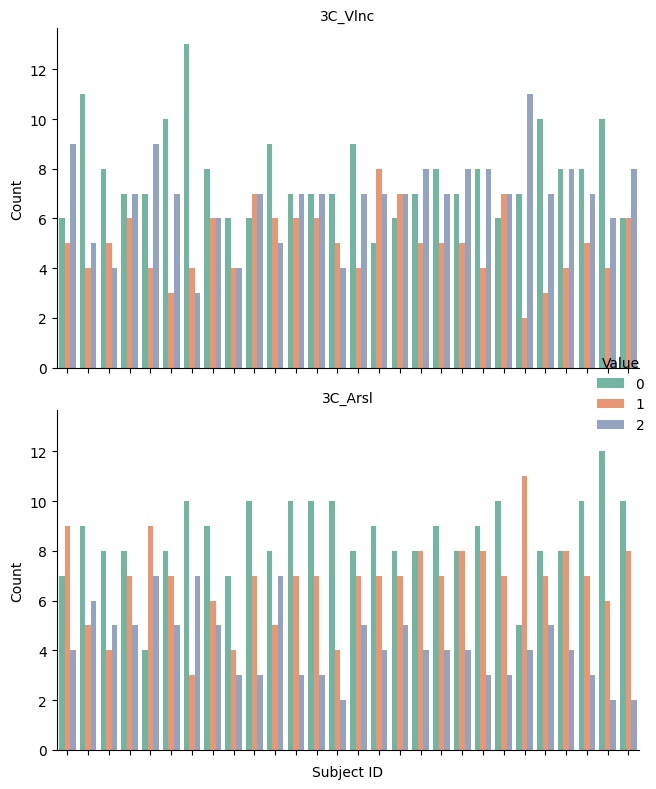

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 3C_Vlnc와 3C_Arsl을 row로 구분하기 위해 melt
df_melt = df.melt(
    id_vars="subject_id",
    value_vars=["3C_Vlnc", "3C_Arsl"],
    var_name="Label_Type",
    value_name="Value"
)

# catplot에서 row="Label_Type"로 설정하면, BC_Vlnc와 BC_Arsl이 위아래로 나뉨
g = sns.catplot(
    data=df_melt,
    kind="count",
    x="subject_id",
    hue="Value",
    row="Label_Type",
    row_order=["3C_Vlnc", "3C_Arsl"],  # 순서를 명시적으로 지정
    height=4,
    aspect=1.5,
    palette="Set2",
    dodge=True
)

# 제목, 축 레이블 등 설정
g.set_axis_labels("Subject ID", "Count")
g.set_titles("{row_name}")  # 각 row에 해당하는 레이블 이름(BC_Vlnc, BC_Arsl)

# 범례 제목 설정
if g._legend is not None:
    g._legend.set_title("Value")

# x축 라벨 겹치지 않도록 회전
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


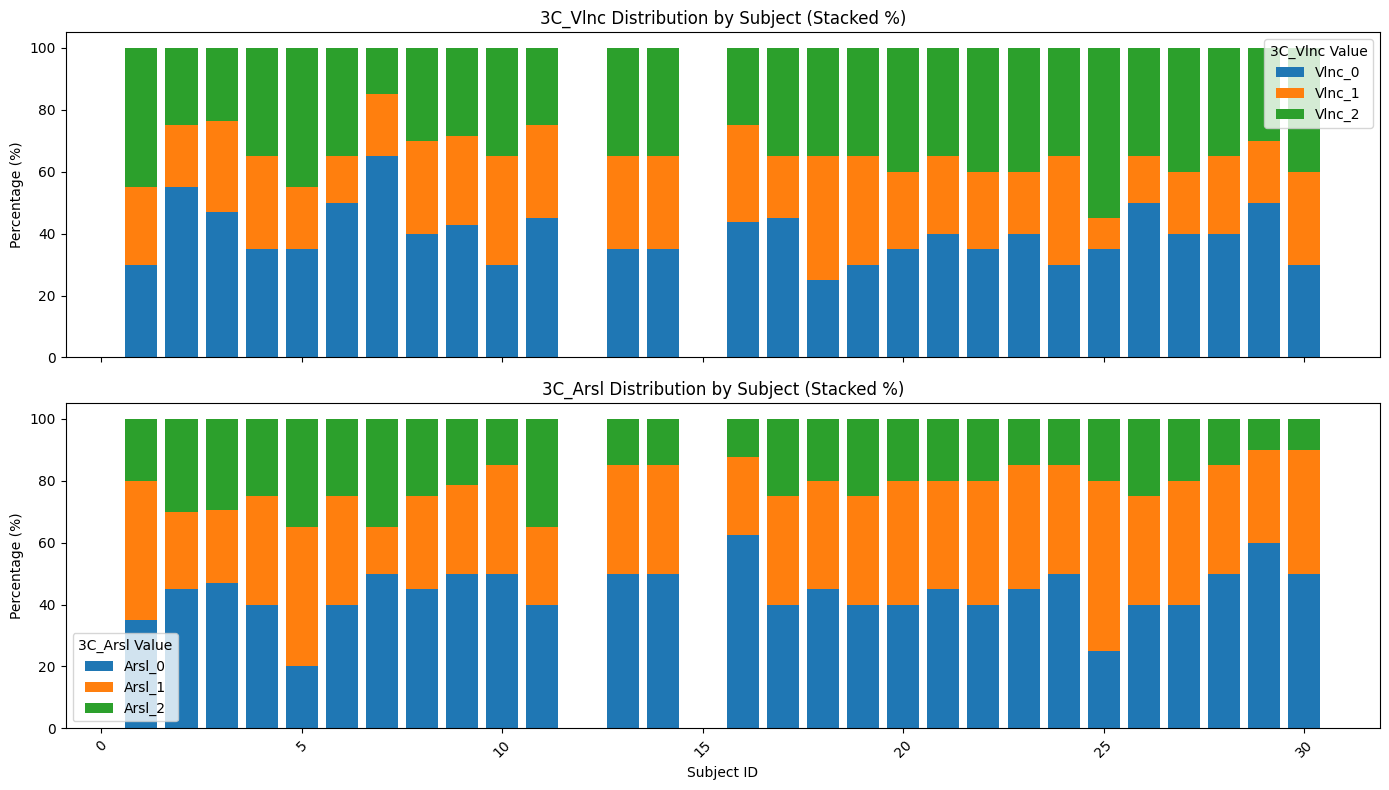

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# For visualization, we assume the CSV now has columns "3C_Vlnc" and "3C_Arsl"
# Group by subject_id and count occurrences for 3C_Vlnc
counts_vlnc = df.groupby(["subject_id", "3C_Vlnc"]).size().unstack(fill_value=0)
# Rename columns for clarity
counts_vlnc.columns = [f"Vlnc_{col}" for col in counts_vlnc.columns]

# Group by subject_id and count occurrences for 3C_Arsl
counts_arsl = df.groupby(["subject_id", "3C_Arsl"]).size().unstack(fill_value=0)
counts_arsl.columns = [f"Arsl_{col}" for col in counts_arsl.columns]

# Sort by subject_id
counts_vlnc = counts_vlnc.sort_index()
counts_arsl = counts_arsl.sort_index()

# Calculate percentage for each subject (row-wise)
counts_vlnc_pct = counts_vlnc.apply(lambda row: row / row.sum() * 100, axis=1)
counts_arsl_pct = counts_arsl.apply(lambda row: row / row.sum() * 100, axis=1)

# Create subplots: 2 rows (upper: 3C_Vlnc, lower: 3C_Arsl)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# Plot stacked bar chart for 3C_Vlnc
bottom = None
for col in counts_vlnc_pct.columns:
    axes[0].bar(counts_vlnc_pct.index, counts_vlnc_pct[col], bottom=bottom, label=col)
    # Update bottom for stacking
    if bottom is None:
        bottom = counts_vlnc_pct[col]
    else:
        bottom += counts_vlnc_pct[col]
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("3C_Vlnc Distribution by Subject (Stacked %)")
axes[0].legend(title="3C_Vlnc Value")

# Plot stacked bar chart for 3C_Arsl
bottom = None
for col in counts_arsl_pct.columns:
    axes[1].bar(counts_arsl_pct.index, counts_arsl_pct[col], bottom=bottom, label=col)
    if bottom is None:
        bottom = counts_arsl_pct[col]
    else:
        bottom += counts_arsl_pct[col]
axes[1].set_xlabel("Subject ID")
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("3C_Arsl Distribution by Subject (Stacked %)")
axes[1].legend(title="3C_Arsl Value")

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
df.head()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR,3C_Arsl,3C_Vlnc,BC_Vlnc,BC_Arsl
0,2762,22,5,6,2,69.031442,0,0,0,1
1,3518,28,5,2,1,61.935484,0,0,0,0
2,670,6,4,6,8,66.580198,1,2,1,1
3,2748,22,0,3,5,69.563572,0,1,1,0
4,2864,23,12,4,3,61.935484,2,0,0,0


In [25]:
df.to_csv('/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv')

# Unsupervised EDA

In [3]:
import os
import numpy as np

# Set the path to the preprocessed data folder (adjust this path accordingly)
cached_path = "/home/changmin/data/MAHNOB_HCI_Emotion_Preprocessed/MAHNOB-HCI_SizeW72_SizeH72_ClipLength180_DataTypeRaw_DataAugNone_LabelTypeRaw_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse_unsupervised"

# Iterate over all npy files that are input files (assuming they contain "input" in the filename)
for file_name in os.listdir(cached_path):
    if file_name.endswith(".npy") and "input" in file_name:
        file_path = os.path.join(cached_path, file_name)
        data = np.load(file_path)
        print(f"{file_name}: shape = {data.shape}")


418_input12.npy: shape = (180, 72, 72, 3)
3808_input1.npy: shape = (180, 72, 72, 3)
3158_input8.npy: shape = (180, 72, 72, 3)
2614_input18.npy: shape = (180, 72, 72, 3)
3664_input15.npy: shape = (180, 72, 72, 3)
2766_input7.npy: shape = (180, 72, 72, 3)
1066_input4.npy: shape = (180, 72, 72, 3)
2234_input5.npy: shape = (180, 72, 72, 3)
550_input6.npy: shape = (180, 72, 72, 3)
3028_input18.npy: shape = (180, 72, 72, 3)
2370_input17.npy: shape = (180, 72, 72, 3)
2634_input14.npy: shape = (180, 72, 72, 3)
268_input7.npy: shape = (180, 72, 72, 3)
3418_input1.npy: shape = (180, 72, 72, 3)
2090_input15.npy: shape = (180, 72, 72, 3)
2734_input0.npy: shape = (180, 72, 72, 3)
2114_input7.npy: shape = (180, 72, 72, 3)
2086_input12.npy: shape = (180, 72, 72, 3)
1062_input2.npy: shape = (180, 72, 72, 3)
942_input18.npy: shape = (180, 72, 72, 3)
1568_input18.npy: shape = (180, 72, 72, 3)
680_input24.npy: shape = (180, 72, 72, 3)
2096_input3.npy: shape = (180, 72, 72, 3)
3000_input14.npy: shape = (1

# EDA

In [4]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [5]:
video_path = "/home/changmin/data/UBFC-rPPG/DATASET_2/subject43/vid.avi"
cap = cv2.VideoCapture(video_path)

In [6]:
if not cap.isOpened():
    print("⚠️ Error: Video file could not be opened. Check the path or file format.")

In [7]:
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"Width: {width}, Height: {height}, FPS: {fps}")
cap.release()

Width: 640.0, Height: 480.0, FPS: 29.342154


In [8]:
folder_path = "/home/changmin/data/UBFC-rPPG/PreprocessedData/UBFC-rPPG_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse"
file_list = [f for f in os.listdir(folder_path) if "input" in f and f.endswith(".npy")]

In [6]:
def sort_key(filename):
    m = re.search(r'subject(\d+)_input(\d+)', filename)
    if m:
        subject = int(m.group(1))
        frame = int(m.group(2))
        return (subject, frame)
    return (0, 0)

In [ ]:
file_list = sorted(file_list, key=sort_key)

KeyboardInterrupt: 

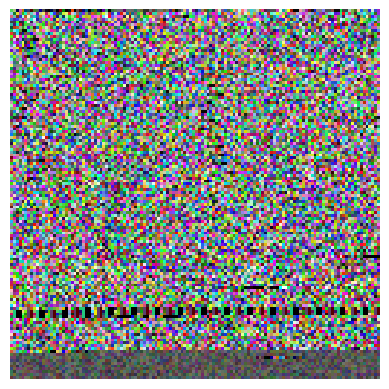

In [10]:
for file in file_list:
    frame = np.load(os.path.join(folder_path, file))
    # 만약 그레이스케일이면 colormap 적용
    if len(frame.shape) == 2:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)


In [ ]:
first_frame = np.load(os.path.join(folder_path, file_list[0]))
height, width = first_frame.shape[:2]
print("Width:", width, "Height:", height)

Width: 128 Height: 128


# MAHNOB format -> NDHWC

In [5]:
import cv2
import numpy as np

avi_path = "/home/changmin/data/MAHNOB_HCI_Emotion/2/2.avi"
cap = cv2.VideoCapture(avi_path)

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

# Convert list of frames to numpy array
frames = np.array(frames)
print("Shape of frames:", frames.shape)

Shape of frames: (7266, 580, 780, 3)


# MAHNOB-HCI Filtering for Emotion Recognition using rPPG DL models

In [ ]:
'''import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import welch, butter, filtfilt, find_peaks

# 🔹 Set paths (adjust if necessary)
source_dir = "/home/changmin/data/Sessions"
output_dir = "/home/changmin/data/MAHNOB_HCI_Emotion"
csv_file = os.path.join(output_dir, "emotion_labels.csv")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to store data entries
data_list = []

# HR calculation function with bandpass filtering (0.04Hz ~ 4Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:  # Return NaN if the signal is too short
        return np.nan  
    # Remove DC offset
    ecg_signal = ecg_signal - np.mean(ecg_signal)
    # Apply bandpass filtering (0.04Hz ~ 4Hz)
    ecg_signal = bandpass_filter(ecg_signal, fs)
    # Detect R-peaks (adjust threshold accordingly)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    if len(peaks) < 2:
        return np.nan  # Return NaN if too few peaks are detected
    # Calculate RR intervals in seconds
    rr_intervals = np.diff(peaks) / fs  
    # Convert to BPM and filter out outliers (40~180 BPM)
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  
    return np.mean(hr_values) if len(hr_values) > 0 else np.nan  # Return average HR

# 🔹 Iterate over session folders
for session in os.listdir(source_dir):
    session_path = os.path.join(source_dir, session)

    if os.path.isdir(session_path):  # Check if it's a directory
        session_number = session  # Session ID (e.g., "10")

        xml_file = None
        video_file = None
        ecg_file = None

        # 🔹 Search for files in the session folder
        for file in os.listdir(session_path):
            # Select XML file
            if file.endswith(".xml"):
                xml_file = os.path.join(session_path, file)
            # Select BDF file for ECG data
            if file.endswith(".bdf"):
                ecg_file = os.path.join(session_path, file)

        # 🔹 If XML file exists, parse it to extract emotion labels and find the RGB video (color="1")
        if xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            felt_emo = root.attrib.get("feltEmo")
            felt_arsl = root.attrib.get("feltArsl")
            felt_vlnc = root.attrib.get("feltVlnc")

            # Process only if labels are available
            if felt_emo is not None:
                entry = {
                    "Session": session_number,  # Save session number
                    "feltEmo": int(felt_emo),
                    "feltArsl": int(felt_arsl),
                    "feltVlnc": int(felt_vlnc),
                    "HR": np.nan  # Initialize HR as NaN
                }

                # Find RGB video: track with type="Video" and color="1"
                for track in root.findall("track"):
                    if track.attrib.get("type") == "Video" and track.attrib.get("color") == "1":
                        video_file = os.path.join(session_path, track.attrib.get("filename"))
                        break

                # 🔹 Calculate HR from ECG using BDF file and selecting best channel HR
                if ecg_file:
                    try:
                        # Read BDF file using pyedflib
                        f = pyedflib.EdfReader(ecg_file)
                        fs = 256  # Sampling frequency (Hz)
                        hr_candidates = []
                        # Process ECG channels: EXG1=33, EXG2=34, EXG3=35
                        for ecg_channel in [33, 34, 35]:
                            try:
                                ecg_signal = f.readSignal(ecg_channel)
                                hr_bpm = calculate_hr(ecg_signal, fs)
                                if not np.isnan(hr_bpm):
                                    hr_candidates.append(hr_bpm)
                                print(f"✅ Session {session_number} - Channel {ecg_channel} - HR: {hr_bpm:.2f} BPM")
                            except Exception as e:
                                print(f"❌ Error in Session {session_number}, Channel {ecg_channel}: {e}")
                        f.close()
                        if len(hr_candidates) > 0:
                            best_hr = np.median(hr_candidates)  # Select median HR
                        else:
                            best_hr = np.nan
                        entry["HR"] = best_hr
                        print(f"✔️ Best HR for Session {session_number}: {best_hr:.2f} BPM")
                    except Exception as e:
                        print(f"❌ HR calculation error (Session {session_number}):", e)
                        entry["HR"] = np.nan

                # 🔹 Save the RGB video file if found
                if video_file:
                    try:
                        target_session_dir = os.path.join(output_dir, session_number)
                        os.makedirs(target_session_dir, exist_ok=True)  # Create session folder
                        target_video_path = os.path.join(target_session_dir, f"{session_number}.avi")
                        shutil.copy(video_file, target_video_path)
                        print(f"🎥 RGB video saved: {target_video_path}")
                    except Exception as e:
                        print(f"❌ Video saving error (Session {session_number}):", e)
                else:
                    print(f"⚠️ No RGB video found for session {session_number}.")

                # Add the entry to the data list
                data_list.append(entry)

# 🔹 Save the updated CSV with HR values
df = pd.DataFrame(data_list)
df.to_csv(csv_file, index=False)

print(f"✅ CSV saved: {csv_file}")
print(f"✅ RGB video saving complete (Total sessions: {len(data_list)})")
'''

✅ Session 2762 - Channel 33 - HR: 69.03 BPM
✅ Session 2762 - Channel 34 - HR: 69.31 BPM
✅ Session 2762 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 2762: 69.03 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/2762/2762.avi
✅ Session 3518 - Channel 33 - HR: 61.20 BPM
✅ Session 3518 - Channel 34 - HR: 68.34 BPM
✅ Session 3518 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 3518: 61.94 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/3518/3518.avi
✅ Session 670 - Channel 33 - HR: 82.14 BPM
✅ Session 670 - Channel 34 - HR: 66.58 BPM
✅ Session 670 - Channel 35 - HR: 63.21 BPM
✔️ Best HR for Session 670: 66.58 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/670/670.avi
✅ Session 2748 - Channel 33 - HR: 68.66 BPM
✅ Session 2748 - Channel 34 - HR: 70.46 BPM
✅ Session 2748 - Channel 35 - HR: nan BPM
✔️ Best HR for Session 2748: 69.56 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/2748/2748.avi
✅ Session 2864 - Channel 33 - HR: 61

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import welch, butter, filtfilt, find_peaks

# 🔹 Set paths (adjust if necessary)
source_dir = "/home/changmin/data/Sessions"
output_dir = "/home/changmin/data/MAHNOB_HCI_Emotion"
csv_file = os.path.join(output_dir, "emotion_labels.csv")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to store data entries
data_list = []

# HR calculation function with bandpass filtering (example: 0.5Hz~40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:
        return np.nan  
    # Remove DC offset
    ecg_signal = ecg_signal - np.mean(ecg_signal)
    # Apply bandpass filtering
    ecg_signal = bandpass_filter(ecg_signal, fs)
    # Detect R-peaks (threshold adjusted)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    if len(peaks) < 2:
        return np.nan  
    rr_intervals = np.diff(peaks) / fs  
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  
    return np.mean(hr_values) if len(hr_values) > 0 else np.nan

# 🔹 Iterate over session folders
for session in os.listdir(source_dir):
    session_path = os.path.join(source_dir, session)

    if os.path.isdir(session_path):  # Check if it's a directory
        session_number = session  # Session ID (e.g., "10")

        xml_file = None
        video_file = None
        ecg_file = None

        # 🔹 Search for files in the session folder
        for file in os.listdir(session_path):
            if file.endswith(".xml"):
                xml_file = os.path.join(session_path, file)
            if file.endswith(".bdf"):
                ecg_file = os.path.join(session_path, file)

        # 🔹 If XML file exists, parse it to extract emotion labels, subject id and find the RGB video (color="1")
        if xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Extract subject id from <subject> tag
            subject_elem = root.find("subject")
            subject_id = subject_elem.attrib.get("id") if subject_elem is not None else None

            felt_emo = root.attrib.get("feltEmo")
            felt_arsl = root.attrib.get("feltArsl")
            felt_vlnc = root.attrib.get("feltVlnc")

            # Process only if emotion labels are available
            if felt_emo is not None:
                entry = {
                    "Session": session_number,      # Session number
                    "subject_id": subject_id,         # Subject ID extracted from XML
                    "feltEmo": int(felt_emo),
                    "feltArsl": int(felt_arsl),
                    "feltVlnc": int(felt_vlnc),
                    "HR": np.nan                    # Initialize HR as NaN
                }

                # Find RGB video: track with type="Video" and color="1"
                for track in root.findall("track"):
                    if track.attrib.get("type") == "Video" and track.attrib.get("color") == "1":
                        video_file = os.path.join(session_path, track.attrib.get("filename"))
                        break

                # 🔹 Calculate HR from ECG using BDF file and best channel selection
                if ecg_file:
                    try:
                        f = pyedflib.EdfReader(ecg_file)
                        fs = 256  # Sampling frequency (Hz)
                        hr_candidates = []
                        for ecg_channel in [33, 34, 35]:
                            try:
                                ecg_signal = f.readSignal(ecg_channel)
                                hr_bpm = calculate_hr(ecg_signal, fs)
                                if not np.isnan(hr_bpm):
                                    hr_candidates.append(hr_bpm)
                                print(f"✅ Session {session_number} - Channel {ecg_channel} - HR: {hr_bpm:.2f} BPM")
                            except Exception as e:
                                print(f"❌ Error in Session {session_number}, Channel {ecg_channel}: {e}")
                        f.close()
                        if len(hr_candidates) > 0:
                            best_hr = np.median(hr_candidates)  # Select median HR
                        else:
                            best_hr = np.nan
                        entry["HR"] = best_hr
                        print(f"✔️ Best HR for Session {session_number}: {best_hr:.2f} BPM")
                    except Exception as e:
                        print(f"❌ HR calculation error (Session {session_number}):", e)
                        entry["HR"] = np.nan

                # 🔹 Save the RGB video file if found
                if video_file:
                    try:
                        target_session_dir = os.path.join(output_dir, session_number)
                        os.makedirs(target_session_dir, exist_ok=True)
                        target_video_path = os.path.join(target_session_dir, f"{session_number}.avi")
                        shutil.copy(video_file, target_video_path)
                        print(f"🎥 RGB video saved: {target_video_path}")
                    except Exception as e:
                        print(f"❌ Video saving error (Session {session_number}):", e)
                else:
                    print(f"⚠️ No RGB video found for session {session_number}.")

                # Add the entry (including subject_id and other info) to the data list
                data_list.append(entry)

# 🔹 Save the updated CSV with all information
df = pd.DataFrame(data_list)
df.to_csv(csv_file, index=False)

print(f"✅ CSV saved: {csv_file}")
print(f"✅ RGB video saving complete (Total sessions: {len(data_list)})")


✅ Session 2762 - Channel 33 - HR: 69.03 BPM
✅ Session 2762 - Channel 34 - HR: 69.31 BPM
✅ Session 2762 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 2762: 69.03 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/2762/2762.avi
✅ Session 3518 - Channel 33 - HR: 61.20 BPM
✅ Session 3518 - Channel 34 - HR: 68.34 BPM
✅ Session 3518 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 3518: 61.94 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/3518/3518.avi
✅ Session 670 - Channel 33 - HR: 82.14 BPM
✅ Session 670 - Channel 34 - HR: 66.58 BPM
✅ Session 670 - Channel 35 - HR: 63.21 BPM
✔️ Best HR for Session 670: 66.58 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/670/670.avi
✅ Session 2748 - Channel 33 - HR: 68.66 BPM
✅ Session 2748 - Channel 34 - HR: 70.46 BPM
✅ Session 2748 - Channel 35 - HR: nan BPM
✔️ Best HR for Session 2748: 69.56 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/2748/2748.avi
✅ Session 2864 - Channel 33 - HR: 61

# Subject 3, 9, 16 Excluded

In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import welch, butter, filtfilt, find_peaks

# 🔹 Set paths (adjust if necessary)
source_dir = "/home/changmin/data/Sessions"
output_dir = "/home/changmin/data/MAHNOB_HCI_Emotion"
csv_file = os.path.join(output_dir, "emotion_labels.csv")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to store data entries
data_list = []

# HR calculation function with bandpass filtering (example: 0.5Hz~40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:
        return np.nan  
    # Remove DC offset
    ecg_signal = ecg_signal - np.mean(ecg_signal)
    # Apply bandpass filtering
    ecg_signal = bandpass_filter(ecg_signal, fs)
    # Detect R-peaks (threshold adjusted)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    if len(peaks) < 2:
        return np.nan  
    rr_intervals = np.diff(peaks) / fs  
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  
    return np.mean(hr_values) if len(hr_values) > 0 else np.nan

# 🔹 Iterate over session folders
for session in os.listdir(source_dir):
    session_path = os.path.join(source_dir, session)

    if os.path.isdir(session_path):  # Check if it's a directory
        session_number = session  # Session ID (e.g., "10")

        xml_file = None
        video_file = None
        ecg_file = None

        # 🔹 Search for files in the session folder
        for file in os.listdir(session_path):
            # Select XML file
            if file.endswith(".xml"):
                xml_file = os.path.join(session_path, file)
            # Select BDF file for ECG data
            if file.endswith(".bdf"):
                ecg_file = os.path.join(session_path, file)

        # 🔹 If XML file exists, parse it to extract emotion labels, subject id and find the RGB video (color="1")
        if xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Extract subject id from <subject> tag
            subject_elem = root.find("subject")
            subject_id = subject_elem.attrib.get("id") if subject_elem is not None else None

            # Exclude sessions with subject id 3, 16, or 9
            if subject_id in ["3", "16", "9"]:
                print(f"⚠️ Skipping session {session_number} due to excluded subject id: {subject_id}")
                continue

            felt_emo = root.attrib.get("feltEmo")
            felt_arsl = root.attrib.get("feltArsl")
            felt_vlnc = root.attrib.get("feltVlnc")

            # Process only if emotion labels are available
            if felt_emo is not None:
                entry = {
                    "Session": session_number,      # Save session number
                    "subject_id": subject_id,         # Save subject id extracted from XML
                    "feltEmo": int(felt_emo),
                    "feltArsl": int(felt_arsl),
                    "feltVlnc": int(felt_vlnc),
                    "HR": np.nan                    # Initialize HR as NaN
                }

                # Find RGB video: track with type="Video" and color="1"
                for track in root.findall("track"):
                    if track.attrib.get("type") == "Video" and track.attrib.get("color") == "1":
                        video_file = os.path.join(session_path, track.attrib.get("filename"))
                        break

                # 🔹 Calculate HR from ECG using BDF file and best channel selection
                if ecg_file:
                    try:
                        f = pyedflib.EdfReader(ecg_file)
                        fs = 256  # Sampling frequency (Hz)
                        hr_candidates = []
                        for ecg_channel in [33, 34, 35]:
                            try:
                                ecg_signal = f.readSignal(ecg_channel)
                                hr_bpm = calculate_hr(ecg_signal, fs)
                                if not np.isnan(hr_bpm):
                                    hr_candidates.append(hr_bpm)
                                print(f"✅ Session {session_number} - Channel {ecg_channel} - HR: {hr_bpm:.2f} BPM")
                            except Exception as e:
                                print(f"❌ Error in Session {session_number}, Channel {ecg_channel}: {e}")
                        f.close()
                        if len(hr_candidates) > 0:
                            best_hr = np.median(hr_candidates)  # Select median HR
                        else:
                            best_hr = np.nan
                        entry["HR"] = best_hr
                        print(f"✔️ Best HR for Session {session_number}: {best_hr:.2f} BPM")
                    except Exception as e:
                        print(f"❌ HR calculation error (Session {session_number}):", e)
                        entry["HR"] = np.nan

                # 🔹 Save the RGB video file if found
                if video_file:
                    try:
                        target_session_dir = os.path.join(output_dir, session_number)
                        os.makedirs(target_session_dir, exist_ok=True)
                        target_video_path = os.path.join(target_session_dir, f"{session_number}.avi")
                        shutil.copy(video_file, target_video_path)
                        print(f"🎥 RGB video saved: {target_video_path}")
                    except Exception as e:
                        print(f"❌ Video saving error (Session {session_number}):", e)
                else:
                    print(f"⚠️ No RGB video found for session {session_number}.")

                # Add the entry to the data list
                data_list.append(entry)

# 🔹 Save the updated CSV with all information
df = pd.DataFrame(data_list)
df.to_csv(csv_file, index=False)

print(f"✅ CSV saved: {csv_file}")
print(f"✅ RGB video saving complete (Total sessions: {len(data_list)})")


⚠️ Skipping session 1057 due to excluded subject id: 9
✅ Session 2762 - Channel 33 - HR: 69.03 BPM
✅ Session 2762 - Channel 34 - HR: 69.31 BPM
✅ Session 2762 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 2762: 69.03 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/2762/2762.avi
✅ Session 3518 - Channel 33 - HR: 61.20 BPM
✅ Session 3518 - Channel 34 - HR: 68.34 BPM
✅ Session 3518 - Channel 35 - HR: 61.94 BPM
✔️ Best HR for Session 3518: 61.94 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/3518/3518.avi
✅ Session 670 - Channel 33 - HR: 82.14 BPM
✅ Session 670 - Channel 34 - HR: 66.58 BPM
✅ Session 670 - Channel 35 - HR: 63.21 BPM
✔️ Best HR for Session 670: 66.58 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emotion/670/670.avi
✅ Session 2748 - Channel 33 - HR: 68.66 BPM
✅ Session 2748 - Channel 34 - HR: 70.46 BPM
✅ Session 2748 - Channel 35 - HR: nan BPM
✔️ Best HR for Session 2748: 69.56 BPM
🎥 RGB video saved: /home/changmin/data/MAHNOB_HCI_Emo

In [14]:
import pandas as pd

df = pd.read_csv('/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv')
df.head()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR
0,2762,22,5,6,2,69.031442
1,3518,28,5,2,1,61.935484
2,670,6,4,6,8,66.580198
3,2748,22,0,3,5,69.563572
4,2864,23,12,4,3,61.935484


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Session     547 non-null    int64  
 1   subject_id  547 non-null    int64  
 2   feltEmo     547 non-null    int64  
 3   feltArsl    547 non-null    int64  
 4   feltVlnc    547 non-null    int64  
 5   HR          547 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 25.8 KB


In [16]:
df.describe()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR
count,547.000000,547.000000,547.000000,547.000000,547.000000,547.000000
mean,1942.354662,15.782450,4.864717,4.539305,4.645338,66.909911
std,1166.421872,8.970149,4.123547,2.248282,2.354637,6.988981
min,2.000000,1.000000,0.000000,1.000000,1.000000,51.787019
25%,866.000000,7.500000,2.000000,3.000000,3.000000,61.935484
50%,2094.000000,17.000000,4.000000,5.000000,5.000000,64.000000
75%,2997.000000,24.000000,11.000000,6.000000,6.500000,69.897367
max,3810.000000,30.000000,12.000000,9.000000,9.000000,96.603774


In [17]:
print(df['subject_id'].value_counts())

subject_id
22    20
28    20
6     20
23    20
20    20
1     20
29    20
4     20
13    20
17    20
24    20
26    20
14    20
2     20
8     20
27    20
5     20
25    20
11    20
18    20
10    20
19    20
7     20
30    20
21    20
3     17
16    16
9     14
Name: count, dtype: int64


## Q: feltArsl == feltVlnc?
### A: 59

In [11]:
same_rows = df[df["feltArsl"] == df["feltVlnc"]]
print("Number of rows where feltArsl equals feltVlnc:", len(same_rows))

Number of rows where feltArsl equals feltVlnc: 59


In [14]:
print("felEmo of feltArsl == feltVlnc rows:\n", same_rows["feltEmo"].value_counts())

felEmo of feltArsl == feltVlnc rows:
 feltEmo
11    14
0     12
5      9
2      8
4      6
12     4
6      3
3      2
1      1
Name: count, dtype: int64


In [16]:
same_rows["feltArsl"].value_counts()

feltArsl
5    12
4    11
3     8
6     7
8     6
2     5
7     5
1     4
9     1
Name: count, dtype: int64

In [15]:
df['feltEmo'].value_counts()

feltEmo
0     113
11    102
4      88
5      69
2      58
3      39
12     36
6      27
1      15
Name: count, dtype: int64

## Only Subject 3, 9, 16 (TEST!!)

In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import welch, butter, filtfilt, find_peaks

# 🔹 Set paths (adjust if necessary)
source_dir = "/home/changmin/data/Sessions"
output_dir = "/home/changmin/data/tmp"
csv_file = os.path.join(output_dir, "emotion_labels.csv")

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to store data entries
data_list = []

# HR calculation function with bandpass filtering (example: 0.5Hz~40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:
        return np.nan  
    # Remove DC offset
    ecg_signal = ecg_signal - np.mean(ecg_signal)
    # Apply bandpass filtering
    ecg_signal = bandpass_filter(ecg_signal, fs)
    # Detect R-peaks (threshold adjusted)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))
    if len(peaks) < 2:
        return np.nan  
    rr_intervals = np.diff(peaks) / fs  
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  
    return np.mean(hr_values) if len(hr_values) > 0 else np.nan

# 🔹 Iterate over session folders
for session in os.listdir(source_dir):
    session_path = os.path.join(source_dir, session)

    if os.path.isdir(session_path):  # Check if it's a directory
        session_number = session  # Session ID (e.g., "10")

        xml_file = None
        video_file = None
        ecg_file = None

        # 🔹 Search for files in the session folder
        for file in os.listdir(session_path):
            # Select XML file
            if file.endswith(".xml"):
                xml_file = os.path.join(session_path, file)
            # Select BDF file for ECG data
            if file.endswith(".bdf"):
                ecg_file = os.path.join(session_path, file)

        # 🔹 If XML file exists, parse it to extract emotion labels, subject id and find the RGB video (color="1")
        if xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Extract subject id from <subject> tag
            subject_elem = root.find("subject")
            subject_id = subject_elem.attrib.get("id") if subject_elem is not None else None

            # Exclude sessions with subject id 3, 16, or 9
            if subject_id not in ["3", "16", "9"]:
                print(f"⚠️ Skipping session {session_number} due to excluded subject id: {subject_id}")
                continue

            felt_emo = root.attrib.get("feltEmo")
            felt_arsl = root.attrib.get("feltArsl")
            felt_vlnc = root.attrib.get("feltVlnc")

            # Process only if emotion labels are available
            if felt_emo is not None:
                entry = {
                    "Session": session_number,      # Save session number
                    "subject_id": subject_id,         # Save subject id extracted from XML
                    "feltEmo": int(felt_emo),
                    "feltArsl": int(felt_arsl),
                    "feltVlnc": int(felt_vlnc),
                    "HR": np.nan                    # Initialize HR as NaN
                }

                # Find RGB video: track with type="Video" and color="1"
                for track in root.findall("track"):
                    if track.attrib.get("type") == "Video" and track.attrib.get("color") == "1":
                        video_file = os.path.join(session_path, track.attrib.get("filename"))
                        break

                # 🔹 Calculate HR from ECG using BDF file and best channel selection
                if ecg_file:
                    try:
                        f = pyedflib.EdfReader(ecg_file)
                        fs = 256  # Sampling frequency (Hz)
                        hr_candidates = []
                        for ecg_channel in [33, 34, 35]:
                            try:
                                ecg_signal = f.readSignal(ecg_channel)
                                hr_bpm = calculate_hr(ecg_signal, fs)
                                if not np.isnan(hr_bpm):
                                    hr_candidates.append(hr_bpm)
                                print(f"✅ Session {session_number} - Channel {ecg_channel} - HR: {hr_bpm:.2f} BPM")
                            except Exception as e:
                                print(f"❌ Error in Session {session_number}, Channel {ecg_channel}: {e}")
                        f.close()
                        if len(hr_candidates) > 0:
                            best_hr = np.median(hr_candidates)  # Select median HR
                        else:
                            best_hr = np.nan
                        entry["HR"] = best_hr
                        print(f"✔️ Best HR for Session {session_number}: {best_hr:.2f} BPM")
                    except Exception as e:
                        print(f"❌ HR calculation error (Session {session_number}):", e)
                        entry["HR"] = np.nan

                # 🔹 Save the RGB video file if found
                if video_file:
                    try:
                        target_session_dir = os.path.join(output_dir, session_number)
                        os.makedirs(target_session_dir, exist_ok=True)
                        target_video_path = os.path.join(target_session_dir, f"{session_number}.avi")
                        shutil.copy(video_file, target_video_path)
                        print(f"🎥 RGB video saved: {target_video_path}")
                    except Exception as e:
                        print(f"❌ Video saving error (Session {session_number}):", e)
                else:
                    print(f"⚠️ No RGB video found for session {session_number}.")

                # Add the entry to the data list
                data_list.append(entry)

# 🔹 Save the updated CSV with all information
df = pd.DataFrame(data_list)
df.to_csv(csv_file, index=False)

print(f"✅ CSV saved: {csv_file}")
print(f"✅ RGB video saving complete (Total sessions: {len(data_list)})")


⚠️ Skipping session 2762 due to excluded subject id: 22
⚠️ Skipping session 3518 due to excluded subject id: 28
⚠️ Skipping session 3795 due to excluded subject id: 30
⚠️ Skipping session 2769 due to excluded subject id: 22
⚠️ Skipping session 3401 due to excluded subject id: 27
⚠️ Skipping session 3007 due to excluded subject id: 24
⚠️ Skipping session 2751 due to excluded subject id: 22
⚠️ Skipping session 921 due to excluded subject id: 8
⚠️ Skipping session 670 due to excluded subject id: 6
⚠️ Skipping session 3261 due to excluded subject id: 26
⚠️ Skipping session 815 due to excluded subject id: 7
⚠️ Skipping session 3267 due to excluded subject id: 26
⚠️ Skipping session 1848 due to excluded subject id: 15
⚠️ Skipping session 2748 due to excluded subject id: 22
⚠️ Skipping session 2864 due to excluded subject id: 23
⚠️ Skipping session 2862 due to excluded subject id: 23
⚠️ Skipping session 2635 due to excluded subject id: 21
⚠️ Skipping session 2480 due to excluded subject id: 2

In [3]:
import pandas as pd

df_tmp = pd.read_csv('/home/changmin/data/tmp/emotion_labels.csv')
df_tmp.head()

,Session,subject_id,feltEmo,feltArsl,feltVlnc,HR
0,1960,16,0,1,4,80.122969
1,1970,16,5,4,4,78.038226
2,1978,16,4,7,7,78.295297
3,284,3,0,1,5,62.323375
4,1966,16,0,3,5,78.970684


In [11]:
grouped = df_tmp.groupby("subject_id")[["feltEmo",'feltArsl', 'feltVlnc']].value_counts()
print(grouped)

subject_id  feltEmo  feltArsl  feltVlnc
3           0        1         5           2
                     2         4           1
            2        1         5           1
                     2         1           1
            3        5         1           1
            4        7         8           1
                               9           1
            5        1         4           1
                     2         1           1
                     5         5           1
            6        1         6           1
                     8         8           1
            11       5         5           1
                               8           1
            12       3         5           1
                     6         3           1
9           0        1         5           1
                     2         5           1
            2        8         2           1
                               3           1
                     9         3           1
            4  

## HR Update

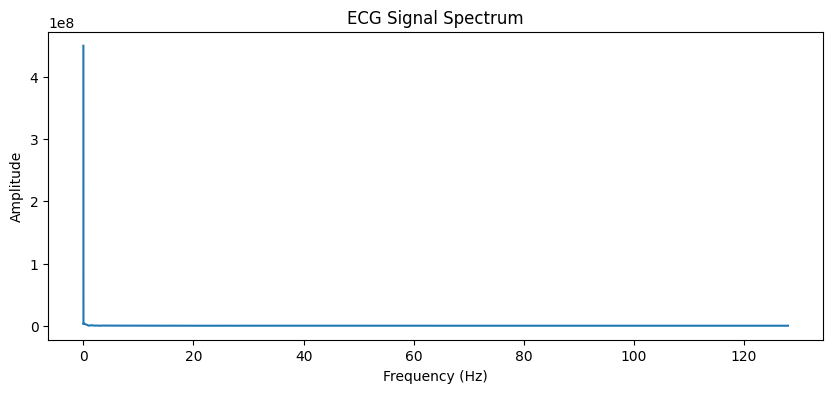

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# ECG 주파수 분석 함수
def plot_ecg_spectrum(ecg_signal, sr=256):
    n = len(ecg_signal)
    freqs = np.fft.fftfreq(n, d=1/sr)
    fft_values = np.abs(fft(ecg_signal))

    plt.figure(figsize=(10, 4))
    plt.plot(freqs[:n//2], fft_values[:n//2])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("ECG Signal Spectrum")
    plt.show()

# 예제 실행 (Session 2045)
# ecg_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/1200/Part_10_S_Trial15_emotion.bdf"
ecg_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"
f = pyedflib.EdfReader(ecg_file_path)
ecg_signal = f.readSignal(31)
f.close()

plot_ecg_spectrum(ecg_signal)


In [28]:
from scipy.signal import find_peaks

# QRS 피크 검출을 이용한 HR 계산 (Welch 변환 제거)
def get_hr_qrs(y, sr=256):
    """QRS 피크 검출을 이용한 HR 계산"""
    if len(y) < sr * 5:
        return np.nan

    # 🔹 0.5~3Hz 대역통과 필터 적용
    y = bandpass_filter(y, lowcut=0.5, highcut=3.0, fs=sr)

    # 🔹 QRS 피크 찾기
    peaks, _ = find_peaks(y, distance=sr*0.5, height=np.mean(y))  # 최소 0.5초 간격, 평균 이상 값만
    if len(peaks) < 2:
        return np.nan

    # 🔹 RR 간격 계산 후 평균 HR 추정
    rr_intervals = np.diff(peaks) / sr  # RR 간격 (초)
    hr = 60 / np.mean(rr_intervals)  # HR 계산 (bpm)

    # 이상한 값 필터링
    if hr < 40 or hr > 150:
        return np.nan

    return hr


## Read BDF File

Extracting EDF parameters from /home/changmin/data/Mahnob_HCI/Sessions/1200/Part_10_S_Trial15_emotion.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 37631  =      0.000 ...   146.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 46 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2009-07-23 17:46:41 UTC
 nchan: 47
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
📌 BDF 채널 목록: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Temp', 'Status']
❌ ECG 채널을 찾을 수 없음!


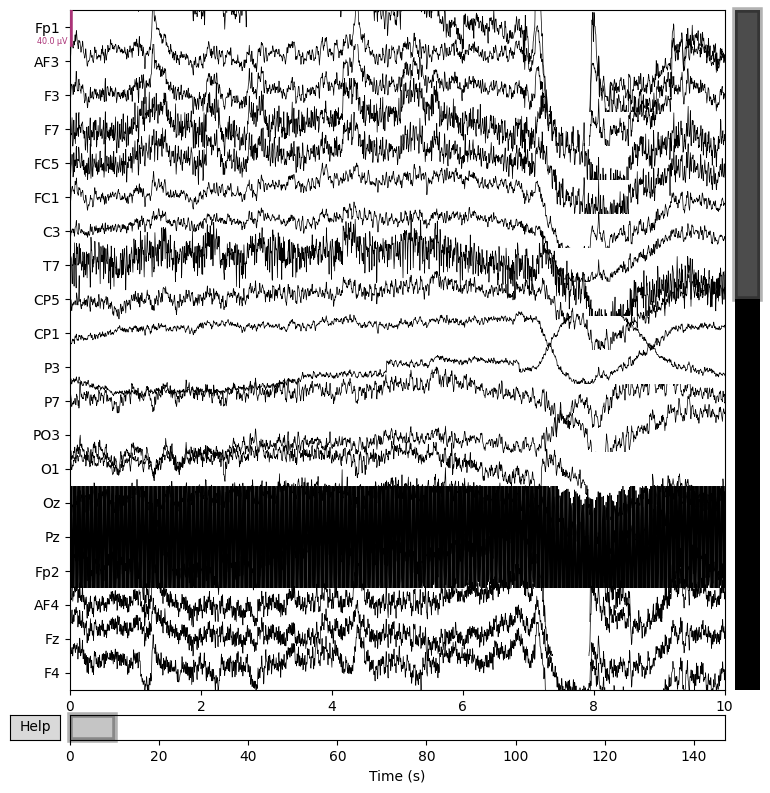

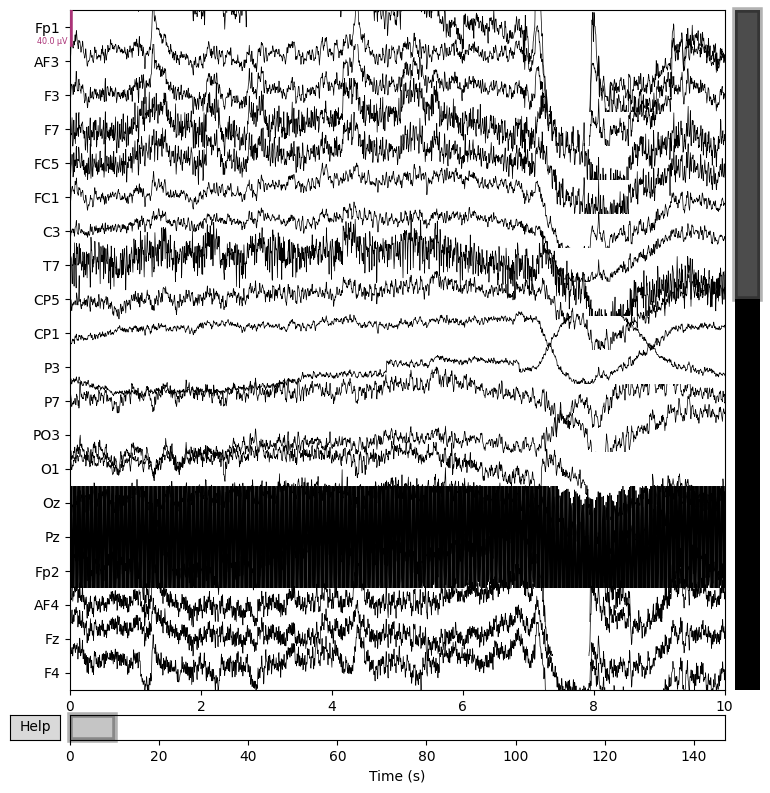

In [ ]:
import mne

# BDF 파일 경로 지정
bdf_file = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"
bdf_file1 = "/home/changmin/data/Mahnob_HCI/Sessions/1200/Part_10_S_Trial15_emotion.bdf"
# BDF 파일 로드
raw = mne.io.read_raw_bdf(bdf_file, preload=True)

# 기본 정보 출력
print(raw.info)
channel_labels = f.getSignalLabels()
f.close()

print("📌 BDF 채널 목록:", channel_labels)

# ECG 채널 찾기
ecg_channel_idx = None
for i, label in enumerate(channel_labels):
    if "ECG" in label.upper() or "EKG" in label.upper():
        ecg_channel_idx = i
        break

if ecg_channel_idx is None:
    print("❌ ECG 채널을 찾을 수 없음!")
else:
    print(f"✅ ECG 채널 번호: {ecg_channel_idx}")
# 데이터 플롯
raw.plot()


In [41]:
import pyedflib

bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"
bdf_file_path1 = "/home/changmin/data/Mahnob_HCI/Sessions/1200/Part_10_S_Trial15_emotion.bdf"

# BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# 모든 채널 이름 확인
channel_names = f.getSignalLabels()

# 표에서 확인한 ECG 관련 채널 (EXG1~EXG3)
ecg_channels = ["EXG1", "EXG2", "EXG3"]

# 실제 BDF 파일에서 존재하는지 확인
available_ecg_channels = [ch for ch in channel_names if ch in ecg_channels]

print(f"📌 BDF 파일의 전체 채널 목록:\n{channel_names}\n")
print(f"✅ 실제 존재하는 ECG 채널:\n{available_ecg_channels}")

f.close()


📌 BDF 파일의 전체 채널 목록:
['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Temp', 'Status']

✅ 실제 존재하는 ECG 채널:
['EXG1', 'EXG2', 'EXG3']


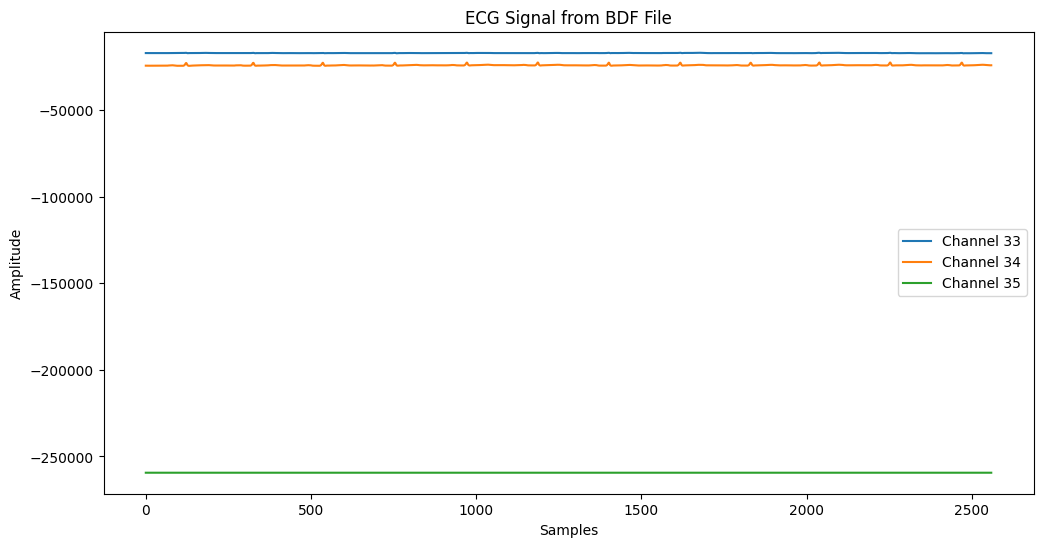

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# 표에서 확인한 ECG 채널 (EXG1, EXG2, EXG3)
ecg_channel_indices = [33, 34, 35]  # 채널 번호

# 10초 분량의 신호를 읽어서 그래프 그리기
plt.figure(figsize=(12, 6))
for i, ch in enumerate(ecg_channel_indices):
    try:
        ecg_signal = f.readSignal(ch)
        plt.plot(ecg_signal[:256*10], label=f"Channel {ch}")  # 10초 분량
    except:
        print(f"⚠️ 채널 {ch}에서 신호를 읽을 수 없음!")

f.close()

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("ECG Signal from BDF File")
plt.legend()
plt.show()


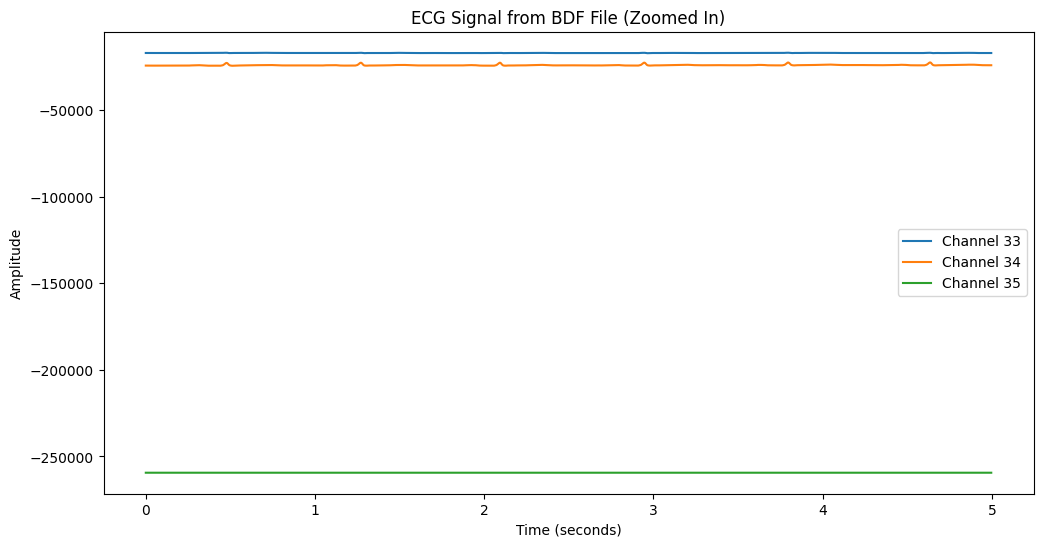

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib


# BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# ECG 채널 (EXG1, EXG2, EXG3)
ecg_channel_indices = [33, 34, 35]

# 샘플링 주파수 (BDF 기본값: 256Hz)
sampling_rate = 256  

# 시각화할 샘플 수 (예: 5초간의 신호만 보기)
duration = 5  # 초
num_samples = duration * sampling_rate

# 5초간의 신호 플로팅
plt.figure(figsize=(12, 6))
for ch in ecg_channel_indices:
    try:
        ecg_signal = f.readSignal(ch)[:num_samples]  # 앞부분 5초만 보기
        plt.plot(np.arange(len(ecg_signal)) / sampling_rate, ecg_signal, label=f"Channel {ch}")
    except:
        print(f"⚠️ 채널 {ch}에서 신호를 읽을 수 없음!")

f.close()

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("ECG Signal from BDF File (Zoomed In)")
plt.legend()
plt.show()


read -1, less than 35328 requested!!!
read -1, less than 35328 requested!!!
read -1, less than 35328 requested!!!


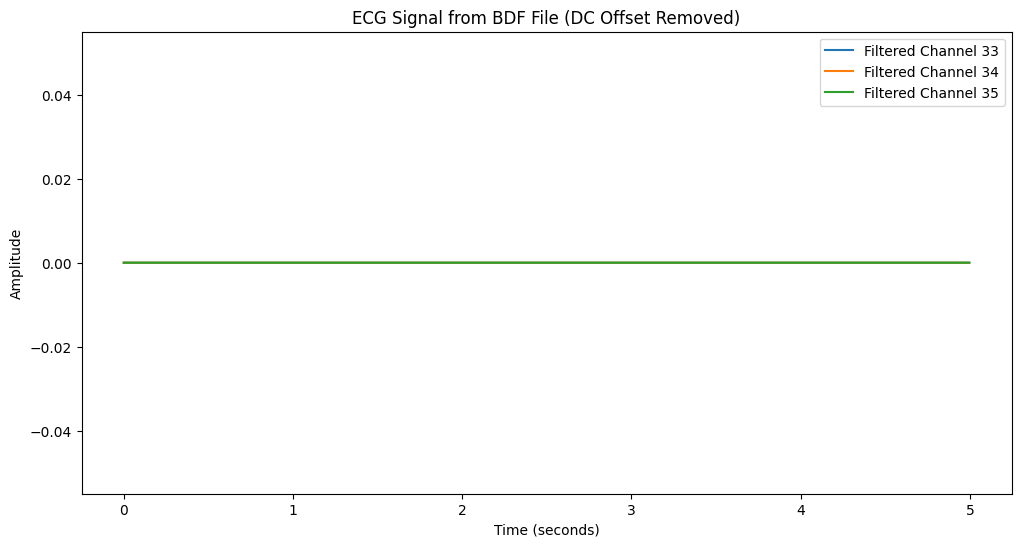

In [44]:
from scipy.signal import butter, filtfilt

# 🔹 DC 성분 제거 필터 (고주파 필터)
def remove_dc_offset(signal, sr=256):
    nyq = 0.5 * sr
    lowcut = 0.5 / nyq  # 0.5Hz 이하 제거 (DC 성분 포함)
    b, a = butter(1, lowcut, btype='high')
    return filtfilt(b, a, signal)

# 5초간의 신호 플로팅 (DC 오프셋 제거 적용)
plt.figure(figsize=(12, 6))
for ch in ecg_channel_indices:
    try:
        ecg_signal = f.readSignal(ch)[:num_samples]
        ecg_signal_filtered = remove_dc_offset(ecg_signal, sampling_rate)
        plt.plot(np.arange(len(ecg_signal_filtered)) / sampling_rate, ecg_signal_filtered, label=f"Filtered Channel {ch}")
    except:
        print(f"⚠️ 채널 {ch}에서 신호를 읽을 수 없음!")

f.close()

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("ECG Signal from BDF File (DC Offset Removed)")
plt.legend()
plt.show()


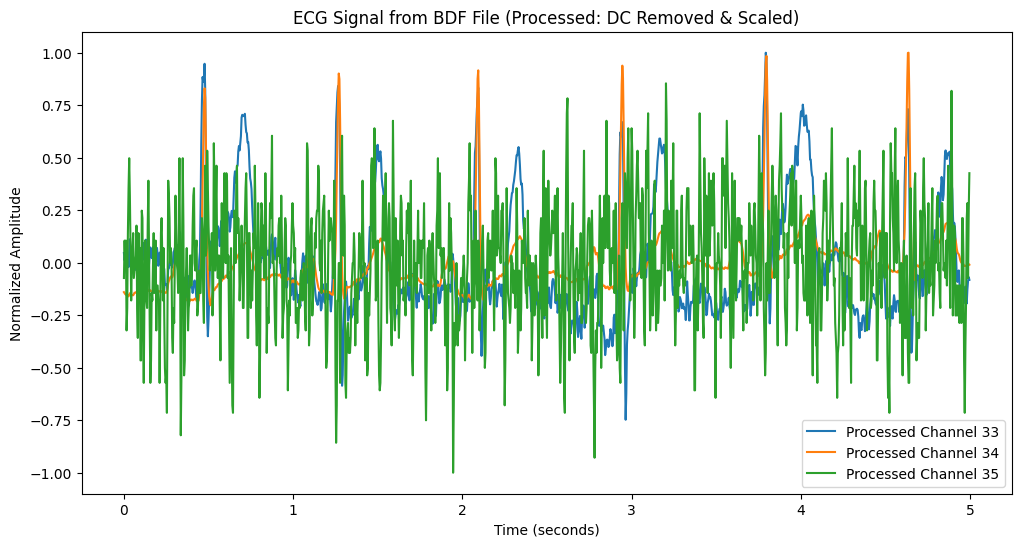

In [45]:
# 🔹 ECG 채널 (EXG1, EXG2, EXG3)
ecg_channel_indices = [33, 34, 35]

# 샘플링 주파수
sampling_rate = 256

# 시각화할 샘플 수 (예: 5초간의 신호만 보기)
duration = 5
num_samples = duration * sampling_rate

# 🔹 DC 제거 및 정규화 함수
def preprocess_ecg(signal):
    """ECG 신호 전처리 (DC 오프셋 제거 + 정규화)"""
    signal = signal - np.mean(signal)  # DC 오프셋 제거
    signal = signal / np.max(np.abs(signal))  # 정규화 (-1 ~ 1 범위)
    return signal

# 🔹 BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# 🔹 ECG 신호 플로팅
plt.figure(figsize=(12, 6))
for ch in ecg_channel_indices:
    try:
        ecg_signal = f.readSignal(ch)[:num_samples]  # 앞부분 5초
        ecg_signal = preprocess_ecg(ecg_signal)  # DC 오프셋 제거 및 정규화
        plt.plot(np.arange(len(ecg_signal)) / sampling_rate, ecg_signal, label=f"Processed Channel {ch}")
    except:
        print(f"⚠️ 채널 {ch}에서 신호를 읽을 수 없음!")

f.close()

plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Amplitude")
plt.title("ECG Signal from BDF File (Processed: DC Removed & Scaled)")
plt.legend()
plt.show()

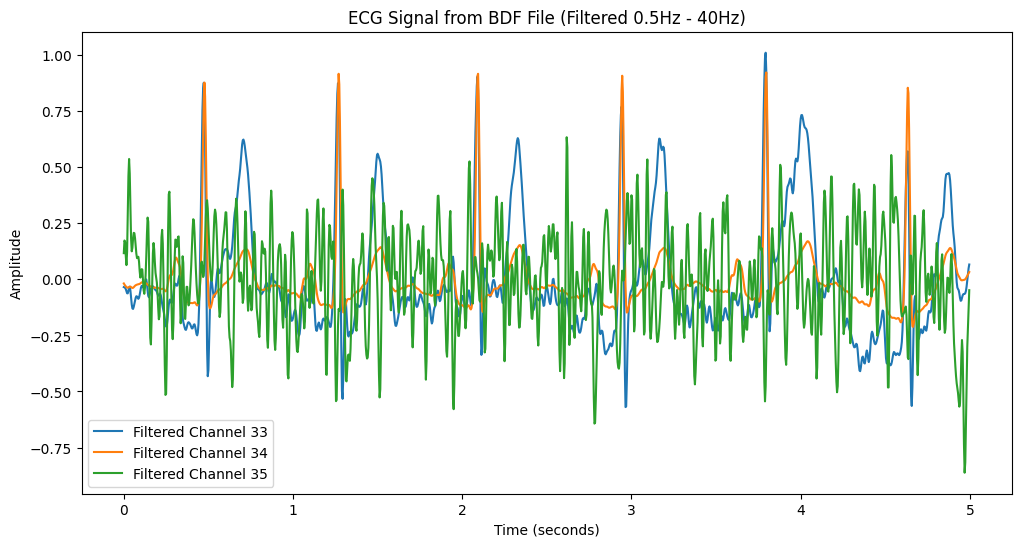

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy.signal import butter, filtfilt

# 🔹 BDF 파일 경로
bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"

# 🔹 ECG 채널 (EXG1, EXG2, EXG3)
ecg_channel_indices = [33, 34, 35]

# 샘플링 주파수
sampling_rate = 256

# 시각화할 샘플 수 (예: 5초간의 신호만 보기)
duration = 5
num_samples = duration * sampling_rate

# 🔹 대역통과 필터 (0.5Hz ~ 40Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=256, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# 🔹 DC 제거 및 정규화 함수
def preprocess_ecg(signal):
    """ECG 신호 전처리 (DC 오프셋 제거 + 정규화)"""
    if len(signal) == 0 or np.all(signal == 0):  # 빈 신호 확인
        print("❌ Warning: 신호가 비어 있음!")
        return None
    
    signal = signal - np.mean(signal)  # DC 오프셋 제거
    max_val = np.max(np.abs(signal))
    
    if max_val == 0 or np.isnan(max_val):  # 정규화 가능 여부 확인
        print("⚠️ Warning: 신호가 0으로만 구성됨. 정규화 생략.")
        return None
    
    return signal / max_val  # 정규화 (-1 ~ 1 범위)

# 🔹 BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# 🔹 ECG 신호 플로팅
plt.figure(figsize=(12, 6))
for ch in ecg_channel_indices:
    try:
        ecg_signal = f.readSignal(ch)
        
        if ecg_signal is None or len(ecg_signal) < num_samples:
            print(f"⚠️ 채널 {ch}에서 충분한 데이터를 읽을 수 없음!")
            continue
        
        ecg_signal = ecg_signal[:num_samples]  # 앞부분 5초만 추출
        ecg_signal = preprocess_ecg(ecg_signal)  # DC 제거 및 정규화
        
        if ecg_signal is None:  # 정규화 불가능한 경우 건너뛰기
            continue
        
        ecg_signal = bandpass_filter(ecg_signal)  # 필터링 적용
        plt.plot(np.arange(len(ecg_signal)) / sampling_rate, ecg_signal, label=f"Filtered Channel {ch}")
    
    except Exception as e:
        print(f"❌ 채널 {ch}에서 신호를 읽을 수 없음! 오류: {e}")

f.close()

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("ECG Signal from BDF File (Filtered 0.5Hz - 40Hz)")
plt.legend()
plt.show()


In [50]:
# 🔹 BDF 파일 정보 확인 코드
bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"

# BDF 파일 열기
f = pyedflib.EdfReader(bdf_file_path)

# 채널 개수 확인
num_channels = f.signals_in_file
channel_labels = f.getSignalLabels()

print(f"✅ BDF 파일 로드 완료! 총 {num_channels}개 채널 탐색 가능")
print(f"📌 채널 목록: {channel_labels}")

# 각 채널의 샘플 수 확인
for ch in range(num_channels):
    signal_length = f.getNSamples()[ch]
    print(f"🔍 채널 {ch} ({channel_labels[ch]}) - 샘플 수: {signal_length}")

f.close()


✅ BDF 파일 로드 완료! 총 47개 채널 탐색 가능
📌 채널 목록: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Temp', 'Status']
🔍 채널 0 (Fp1) - 샘플 수: 35328
🔍 채널 1 (AF3) - 샘플 수: 35328
🔍 채널 2 (F3) - 샘플 수: 35328
🔍 채널 3 (F7) - 샘플 수: 35328
🔍 채널 4 (FC5) - 샘플 수: 35328
🔍 채널 5 (FC1) - 샘플 수: 35328
🔍 채널 6 (C3) - 샘플 수: 35328
🔍 채널 7 (T7) - 샘플 수: 35328
🔍 채널 8 (CP5) - 샘플 수: 35328
🔍 채널 9 (CP1) - 샘플 수: 35328
🔍 채널 10 (P3) - 샘플 수: 35328
🔍 채널 11 (P7) - 샘플 수: 35328
🔍 채널 12 (PO3) - 샘플 수: 35328
🔍 채널 13 (O1) - 샘플 수: 35328
🔍 채널 14 (Oz) - 샘플 수: 35328
🔍 채널 15 (Pz) - 샘플 수: 35328
🔍 채널 16 (Fp2) - 샘플 수: 35328
🔍 채널 17 (AF4) - 샘플 수: 35328
🔍 채널 18 (Fz) - 샘플 수: 35328
🔍 채널 19 (F4) - 샘플 수: 35328
🔍 채널 20 (F8) - 샘플 수: 35328
🔍 채널 21 (FC6) - 샘플 수: 35328
🔍 채널 22 (FC2) - 샘플 수: 35328
🔍 채널 23 (

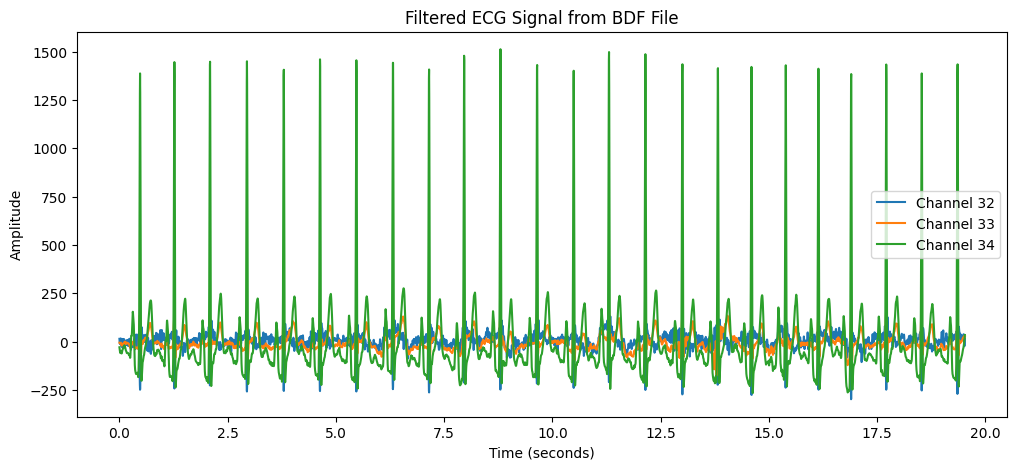

In [51]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# 🔹 BDF 파일 경로
bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"

# 🔹 ECG 채널 (EXG1~EXG3)
ecg_channels = [32, 33, 34]

# 🔹 필터 적용 (0.5Hz ~ 40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# 🔹 BDF 파일 읽기
f = pyedflib.EdfReader(bdf_file_path)
fs = 256  # 샘플링 주파수 (Hz)

plt.figure(figsize=(12, 5))

for ch in ecg_channels:
    signal = f.readSignal(ch)
    signal = bandpass_filter(signal)  # 필터링 적용
    time_axis = np.linspace(0, len(signal) / fs, len(signal))

    plt.plot(time_axis[:5000], signal[:5000], label=f"Channel {ch}")  # 5초만 표시

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Filtered ECG Signal from BDF File")
plt.legend()
plt.show()
f.close()


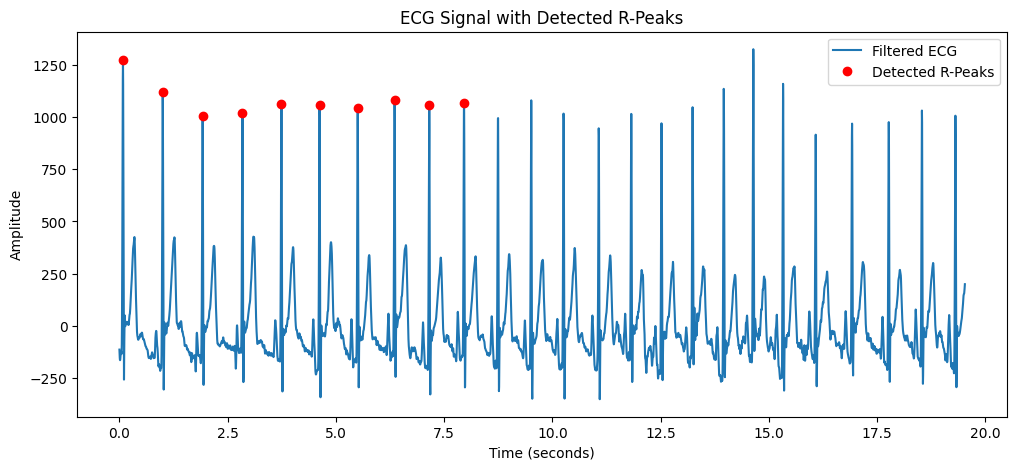

✅ 평균 HR: 69.31 BPM


In [71]:
import numpy as np
import pyedflib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# 🔹 BDF 파일 경로
#bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/4/Part_1_S_Trial2_emotion.bdf"
bdf_file_path = "/home/changmin/data/Mahnob_HCI/Sessions/2762/Part_22_S_Trial16_emotion.bdf"
# 🔹 ECG 채널 선택 (EXG3: Channel 34)
ecg_channel = 34

# 🔹 필터 적용 (0.5Hz ~ 40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# 🔹 BDF 파일 읽기
f = pyedflib.EdfReader(bdf_file_path)
fs = 256  # 샘플링 주파수 (Hz)
signal = f.readSignal(ecg_channel)
signal = bandpass_filter(signal)  # 필터링 적용
time_axis = np.linspace(0, len(signal) / fs, len(signal))

# 🔹 R-peak 감지 (심전도 파형의 R 피크 찾기)
peaks, _ = find_peaks(signal, distance=fs*0.6, height=np.mean(signal) + np.std(signal))  # 최소 0.6초 간격

# 🔹 HR 계산
rr_intervals = np.diff(peaks) / fs  # RR 간격 (초 단위)
hr_values = 60 / rr_intervals  # BPM 변환

# 🔹 그래프 표시
plt.figure(figsize=(12, 5))
plt.plot(time_axis[:5000], signal[:5000], label="Filtered ECG")
plt.plot(time_axis[peaks[:10]], signal[peaks[:10]], "ro", label="Detected R-Peaks")  # 처음 10개 피크만 표시
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-Peaks")
plt.legend()
plt.show()

# 🔹 평균 HR 출력
mean_hr = np.mean(hr_values)
print(f"✅ 평균 HR: {mean_hr:.2f} BPM")

f.close()


## Appropriate HR Calculation FINALLY

In [75]:
import os
import glob
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import butter, filtfilt, find_peaks

# ✅ Bandpass 필터 (0.5Hz ~ 40Hz) 적용 함수
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# ✅ HR 계산 함수 (기존 방식 유지)
def calculate_hr(ecg_signal, fs):
    # DC Offset 제거
    ecg_signal = ecg_signal - np.mean(ecg_signal)

    # Bandpass 필터링 적용
    ecg_signal = bandpass_filter(ecg_signal, fs)

    # R-peak 검출 (기존 방식 그대로 유지)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))

    if len(peaks) < 2:
        return np.nan  # R-peak가 너무 적으면 NaN 반환

    # RR 간격 계산 (초 단위)
    rr_intervals = np.diff(peaks) / fs  

    # BPM 변환 및 이상치 제거 (40~180 BPM)
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  

    return np.mean(hr_values) if len(hr_values) > 0 else np.nan  # 평균 HR 반환

# ✅ 기존 CSV 불러오기
csv_path = "/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv"
df = pd.read_csv(csv_path)

# ✅ 새로운 HR을 저장할 리스트
new_hr_values = []

# ✅ 세션 기반으로 BDF 파일을 읽어서 HR 계산
base_bdf_path = "/home/changmin/data/Mahnob_HCI/Sessions"

for index, row in df.iterrows():
    session = str(int(row["Session"]))  # 세션 ID 가져오기 (정수 변환)
    session_folder = os.path.join(base_bdf_path, session)

    # 📌 해당 세션 폴더에서 BDF 파일 자동 탐색
    bdf_files = glob.glob(os.path.join(session_folder, "*.bdf"))

    if len(bdf_files) == 0:
        print(f"⚠️ BDF 파일 없음: {session_folder}")
        new_hr_values.append(np.nan)  # HR을 NaN으로 설정
        continue

    bdf_file = bdf_files[0]  # 첫 번째 발견된 BDF 파일 사용

    try:
        # ✅ BDF 파일 읽기 (pyedflib 사용)
        f = pyedflib.EdfReader(bdf_file)
        fs = 256  # 샘플링 주파수 (Hz)

        # ✅ ECG 채널 선택 (EXG2 = 34번 채널)
        ecg_channel = 34  
        signal = f.readSignal(ecg_channel)

        # ✅ HR 계산
        hr_bpm = calculate_hr(signal, fs)

        # ✅ HR 리스트에 추가
        new_hr_values.append(hr_bpm)

        print(f"✅ Session {session} - HR: {hr_bpm:.2f} BPM")

    except Exception as e:
        print(f"❌ 에러 발생 - Session {session}: {e}")
        new_hr_values.append(np.nan)

# ✅ 새로운 HR 값을 기존 DataFrame에 업데이트
df["HR"] = new_hr_values

# ✅ 업데이트된 CSV 저장
updated_csv_path = "/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels_updated.csv"
df.to_csv(updated_csv_path, index=False)

print(f"✅ 업데이트 완료! 새로운 CSV 저장 -> {updated_csv_path}")


✅ Session 2762 - HR: 69.31 BPM
✅ Session 3518 - HR: 68.34 BPM
✅ Session 670 - HR: 66.58 BPM
✅ Session 2748 - HR: 70.46 BPM
✅ Session 2864 - HR: 84.14 BPM
✅ Session 2862 - HR: 86.05 BPM
✅ Session 2480 - HR: 67.08 BPM
✅ Session 26 - HR: 68.62 BPM
✅ Session 3680 - HR: 69.27 BPM
✅ Session 394 - HR: 69.81 BPM
✅ Session 3664 - HR: 72.31 BPM
✅ Session 1574 - HR: 53.46 BPM
✅ Session 2090 - HR: 67.41 BPM
✅ Session 2998 - HR: 63.87 BPM
✅ Session 3282 - HR: 86.32 BPM
✅ Session 18 - HR: 69.17 BPM
✅ Session 1692 - HR: 82.56 BPM
✅ Session 136 - HR: 70.28 BPM
✅ Session 2888 - HR: 79.84 BPM
✅ Session 932 - HR: 80.64 BPM
✅ Session 3402 - HR: 59.53 BPM
✅ Session 560 - HR: 82.54 BPM
✅ Session 3158 - HR: 79.50 BPM
✅ Session 2872 - HR: 85.01 BPM
✅ Session 3384 - HR: 56.31 BPM
✅ Session 3540 - HR: 69.49 BPM
✅ Session 550 - HR: 82.53 BPM
✅ Session 1318 - HR: 86.71 BPM
✅ Session 3642 - HR: 70.35 BPM
✅ Session 3130 - HR: 84.95 BPM
✅ Session 3028 - HR: 64.55 BPM
✅ Session 2228 - HR: 54.63 BPM
✅ Session 36 - HR:

✅ ECG 신호 길이: 40704
✅ ECG 신호 첫 10개 샘플: [259258.09908057 259258.13033051 259257.91158091 259257.78658115
 259258.00533074 259258.03658068 259258.13033051 259258.41157999
 259258.34908011 259258.16158045]
✅ ECG 신호 최소값: 0.015624047258711526, 최대값: 259259.4428280856
✅ ECG 신호 평균값: 258829.93198050474, 표준편차: 10509.717801323546
🔎 채널 33 - 길이: 40704, 최소값: -3947.1958325025917, 최대값: 0.015624047258711526, 평균: -3237.935335997061, 표준편차: 265.56797513859567
🔎 채널 34 - 길이: 40704, 최소값: 0.015624047258711526, 최대값: 259259.4428280856, 평균: 258829.93198050474, 표준편차: 10509.717801323546
🔎 채널 35 - 길이: 40704, 최소값: -259421.1300311762, 최대값: 0.015624047258711526, 평균: -258992.33604593898, 표준편차: 10516.313432043698


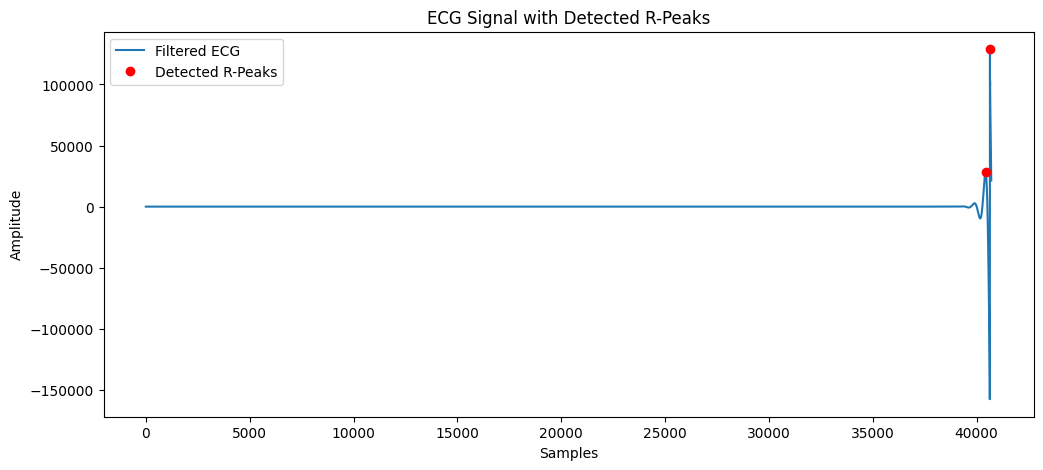

In [85]:
import pyedflib
import numpy as np

bdf_file = "/home/changmin/data/Mahnob_HCI/Sessions/1050/Part_9_S_Trial5_emotion.bdf"

f = pyedflib.EdfReader(bdf_file)
ecg_channel = 34  # ECG 채널 번호 (EXG2)
signal = f.readSignal(ecg_channel)

print(f"✅ ECG 신호 길이: {len(signal)}")
print(f"✅ ECG 신호 첫 10개 샘플: {signal[:10]}")
print(f"✅ ECG 신호 최소값: {np.min(signal)}, 최대값: {np.max(signal)}")
print(f"✅ ECG 신호 평균값: {np.mean(signal)}, 표준편차: {np.std(signal)}")

for ch in [33, 34, 35]:
    signal = f.readSignal(ch)
    print(f"🔎 채널 {ch} - 길이: {len(signal)}, 최소값: {np.min(signal)}, 최대값: {np.max(signal)}, 평균: {np.mean(signal)}, 표준편차: {np.std(signal)}")

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# ✅ Bandpass 필터 함수
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# ✅ ECG 신호 필터링 및 피크 검출
fs = 256  # 샘플링 주파수
filtered_signal = bandpass_filter(signal, fs)
peaks, _ = find_peaks(filtered_signal, height=np.mean(filtered_signal) + np.std(filtered_signal), distance=fs * 0.6)

# ✅ 결과 시각화
plt.figure(figsize=(12, 5))
plt.plot(filtered_signal, label="Filtered ECG")
plt.plot(peaks, filtered_signal[peaks], "ro", label="Detected R-Peaks")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-Peaks")
plt.show()


✅ Session 1050 - Recalculated HR: 72.80 BPM


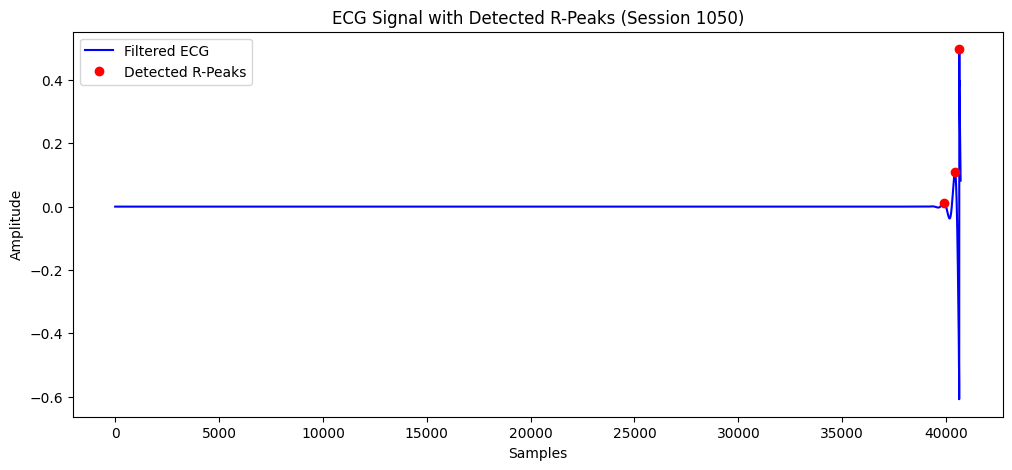

In [94]:
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# ✅ Bandpass 필터 함수 (0.5Hz ~ 40Hz)
def bandpass_filter(signal, fs=256, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# ✅ BDF 파일 읽기 (Session 1050)
bdf_file = "/home/changmin/data/Mahnob_HCI/Sessions/1050/Part_9_S_Trial5_emotion.bdf"
f = pyedflib.EdfReader(bdf_file)

ecg_channel = 35  # EXG2 채널 (ECG 신호)
fs = 256  # 샘플링 주파수 (Hz)
signal = f.readSignal(ecg_channel)

# ✅ DC 오프셋 제거 및 정규화
signal = signal - np.mean(signal)  # DC 제거
signal = signal / np.max(np.abs(signal))  # 정규화 (-1 ~ 1 범위)

# ✅ 필터링 적용
filtered_signal = bandpass_filter(signal, fs)

# ✅ R-peak 감지
peaks, _ = find_peaks(filtered_signal, height=np.mean(filtered_signal) + np.std(filtered_signal) * 0.5, distance=fs * 0.6)

# ✅ HR 계산
if len(peaks) > 1:
    rr_intervals = np.diff(peaks) / fs  # RR 간격 (초 단위)
    hr_values = 60 / rr_intervals  # BPM 변환
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  # 이상치 제거
    hr_bpm = np.mean(hr_values) if len(hr_values) > 0 else np.nan
else:
    hr_bpm = np.nan

# ✅ 결과 출력
print(f"✅ Session 1050 - Recalculated HR: {hr_bpm:.2f} BPM")

# ✅ 신호 시각화 (R-peak 감지 확인)
plt.figure(figsize=(12, 5))
plt.plot(filtered_signal, label="Filtered ECG", color="blue")
plt.plot(peaks, filtered_signal[peaks], "ro", label="Detected R-Peaks")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-Peaks (Session 1050)")
plt.show()


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import pyedflib
from scipy.signal import butter, filtfilt, find_peaks

# ✅ Bandpass 필터 (0.04Hz ~ 4Hz) 적용 함수
def bandpass_filter(signal, fs=256, lowcut=0.04, highcut=4, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

# ✅ HR 계산 함수
def calculate_hr(ecg_signal, fs):
    if ecg_signal is None or len(ecg_signal) < fs:  # 신호 길이가 너무 짧으면 NaN 반환
        return np.nan  

    # DC Offset 제거
    ecg_signal = ecg_signal - np.mean(ecg_signal)

    # Bandpass 필터링 적용
    ecg_signal = bandpass_filter(ecg_signal, fs)

    # R-peak 검출 (임계값 조정)
    peaks, _ = find_peaks(ecg_signal, distance=fs*0.6, height=np.mean(ecg_signal) + np.std(ecg_signal))

    if len(peaks) < 2:
        return np.nan  # R-peak가 너무 적으면 NaN 반환

    # RR 간격 계산 (초 단위)
    rr_intervals = np.diff(peaks) / fs  

    # BPM 변환 및 이상치 제거 (40~180 BPM)
    hr_values = 60 / rr_intervals  
    hr_values = hr_values[(hr_values > 40) & (hr_values < 180)]  

    return np.mean(hr_values) if len(hr_values) > 0 else np.nan  # 평균 HR 반환

# ✅ 기존 CSV 불러오기
csv_path = "/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels.csv"
df = pd.read_csv(csv_path)

# ✅ 새로운 HR을 저장할 리스트
new_hr_values = []

# ✅ 세션 기반으로 BDF 파일을 읽어서 HR 계산
base_bdf_path = "/home/changmin/data/Mahnob_HCI/Sessions"

for index, row in df.iterrows():
    session = str(int(row["Session"]))  # 세션 ID 가져오기 (정수 변환)
    session_folder = os.path.join(base_bdf_path, session)

    # 📌 해당 세션 폴더에서 BDF 파일 자동 탐색
    bdf_files = glob.glob(os.path.join(session_folder, "*.bdf"))

    if len(bdf_files) == 0:
        print(f"⚠️ BDF 파일 없음: {session_folder}")
        new_hr_values.append(np.nan)  # HR을 NaN으로 설정
        continue

    bdf_file = bdf_files[0]  # 첫 번째 발견된 BDF 파일 사용

    try:
        # ✅ BDF 파일 읽기 (pyedflib 사용)
        f = pyedflib.EdfReader(bdf_file)
        fs = 256  # 샘플링 주파수 (Hz)

        # ✅ 3개의 ECG 채널 (EXG1=33, EXG2=34, EXG3=35)에서 HR 계산
        hr_candidates = []
        for ecg_channel in [33, 34, 35]:
            try:
                signal = f.readSignal(ecg_channel)
                hr_bpm = calculate_hr(signal, fs)
                if not np.isnan(hr_bpm):
                    hr_candidates.append(hr_bpm)
                print(f"✅ Session {session} - Channel {ecg_channel} - HR: {hr_bpm:.2f} BPM")
            except Exception as e:
                print(f"❌ 에러 발생 - Session {session}, Channel {ecg_channel}: {e}")

        # ✅ 가장 적절한 HR 선택 (중앙값에 가까운 값)
        if len(hr_candidates) > 0:
            best_hr = np.median(hr_candidates)  # 중앙값 선택
        else:
            best_hr = np.nan  # 모든 채널에서 NaN이면 NaN 유지

        # ✅ HR 리스트에 추가
        new_hr_values.append(best_hr)

        print(f"✔️ 최종 선택된 HR - Session {session}: {best_hr:.2f} BPM")

    except Exception as e:
        print(f"❌ 에러 발생 - Session {session}: {e}")
        new_hr_values.append(np.nan)

# ✅ 새로운 HR 값을 기존 DataFrame에 업데이트
df["HR"] = new_hr_values

# ✅ 업데이트된 CSV 저장
updated_csv_path = "/home/changmin/data/MAHNOB_HCI_Emotion/emotion_labels_updated.csv"
df.to_csv(updated_csv_path, index=False)

print(f"✅ 업데이트 완료! 새로운 CSV 저장 -> {updated_csv_path}")


✅ Session 2762 - Channel 33 - HR: 69.03 BPM
✅ Session 2762 - Channel 34 - HR: 69.31 BPM
✅ Session 2762 - Channel 35 - HR: 61.94 BPM
✔️ 최종 선택된 HR - Session 2762: 69.03 BPM
✅ Session 3518 - Channel 33 - HR: 61.20 BPM
✅ Session 3518 - Channel 34 - HR: 68.34 BPM
✅ Session 3518 - Channel 35 - HR: 61.94 BPM
✔️ 최종 선택된 HR - Session 3518: 61.94 BPM
✅ Session 670 - Channel 33 - HR: 82.14 BPM
✅ Session 670 - Channel 34 - HR: 66.58 BPM
✅ Session 670 - Channel 35 - HR: 63.21 BPM
✔️ 최종 선택된 HR - Session 670: 66.58 BPM
✅ Session 2748 - Channel 33 - HR: 68.66 BPM
✅ Session 2748 - Channel 34 - HR: 70.46 BPM
✅ Session 2748 - Channel 35 - HR: nan BPM
✔️ 최종 선택된 HR - Session 2748: 69.56 BPM
✅ Session 2864 - Channel 33 - HR: 61.20 BPM
✅ Session 2864 - Channel 34 - HR: 84.14 BPM
✅ Session 2864 - Channel 35 - HR: 61.94 BPM
✔️ 최종 선택된 HR - Session 2864: 61.94 BPM
✅ Session 2862 - Channel 33 - HR: 71.78 BPM
✅ Session 2862 - Channel 34 - HR: 86.05 BPM
✅ Session 2862 - Channel 35 - HR: 72.45 BPM
✔️ 최종 선택된 HR - Sess